# LUNA - Analysis


## Install Libraries

In [1]:
!pip install diskcache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.2 MB/s eta 0:00:00


# Utils

In [2]:
import collections
import copy
import datetime
import gc
import time
import sys
import math

import numpy as np

In [3]:
IrcTuple = collections.namedtuple('IrcTuple', ['index', 'row', 'col'])
XyzTuple = collections.namedtuple('XyzTuple', ['x', 'y', 'z'])

def irc2xyz(coord_irc, origin_xyz, vxSize_xyz, direction_a):
    cri_a = np.array(coord_irc)[::-1]
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coords_xyz = (direction_a @ (cri_a * vxSize_a)) + origin_a
    return XyzTuple(*coords_xyz)

def xyz2irc(coord_xyz, origin_xyz, vxSize_xyz, direction_a):
    origin_a = np.array(origin_xyz)
    vxSize_a = np.array(vxSize_xyz)
    coord_a = np.array(coord_xyz)
    cri_a = ((coord_a - origin_a) @ np.linalg.inv(direction_a)) / vxSize_a
    cri_a = np.round(cri_a)
    return IrcTuple(int(cri_a[2]), int(cri_a[1]), int(cri_a[0]))

In [4]:
def importstr(module_str, from_=None):
    """
    >>> importstr('os')
    <module 'os' from '.../os.pyc'>
    >>> importstr('math', 'fabs')
    <built-in function fabs>
    """
    if from_ is None and ':' in module_str:
        module_str, from_ = module_str.rsplit(':')

    module = __import__(module_str)
    for sub_str in module_str.split('.')[1:]:
        module = getattr(module, sub_str)

    if from_:
        try:
            return getattr(module, from_)
        except:
            raise ImportError('{}.{}'.format(module_str, from_))
    return module

In [5]:
import logging
import logging.handlers

root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)

# Some libraries attempt to add their own root logger handlers. This is
# annoying and so we get rid of them.
for handler in list(root_logger.handlers):
    root_logger.removeHandler(handler)

logfmt_str = "%(asctime)s %(levelname)-8s pid:%(process)d %(name)s:%(lineno)03d:%(funcName)s %(message)s"
formatter = logging.Formatter(logfmt_str)

streamHandler = logging.StreamHandler()
streamHandler.setFormatter(formatter)
streamHandler.setLevel(logging.DEBUG)

root_logger.addHandler(streamHandler)

In [6]:
log = logging.getLogger('nb')
log.setLevel(logging.DEBUG)

In [7]:
def enumerateWithEstimate(
        iter,
        desc_str,
        start_ndx=0,
        print_ndx=4,
        backoff=None,
        iter_len=None,
):
    """
    In terms of behavior, `enumerateWithEstimate` is almost identical
    to the standard `enumerate` (the differences are things like how
    our function returns a generator, while `enumerate` returns a
    specialized `<enumerate object at 0x...>`).

    However, the side effects (logging, specifically) are what make the
    function interesting.

    :param iter: `iter` is the iterable that will be passed into
        `enumerate`. Required.

    :param desc_str: This is a human-readable string that describes
        what the loop is doing. The value is arbitrary, but should be
        kept reasonably short. Things like `"epoch 4 training"` or
        `"deleting temp files"` or similar would all make sense.

    :param start_ndx: This parameter defines how many iterations of the
        loop should be skipped before timing actually starts. Skipping
        a few iterations can be useful if there are startup costs like
        caching that are only paid early on, resulting in a skewed
        average when those early iterations dominate the average time
        per iteration.

        NOTE: Using `start_ndx` to skip some iterations makes the time
        spent performing those iterations not be included in the
        displayed duration. Please account for this if you use the
        displayed duration for anything formal.

        This parameter defaults to `0`.

    :param print_ndx: determines which loop interation that the timing
        logging will start on. The intent is that we don't start
        logging until we've given the loop a few iterations to let the
        average time-per-iteration a chance to stablize a bit. We
        require that `print_ndx` not be less than `start_ndx` times
        `backoff`, since `start_ndx` greater than `0` implies that the
        early N iterations are unstable from a timing perspective.

        `print_ndx` defaults to `4`.

    :param backoff: This is used to how many iterations to skip before
        logging again. Frequent logging is less interesting later on,
        so by default we double the gap between logging messages each
        time after the first.

        `backoff` defaults to `2` unless iter_len is > 1000, in which
        case it defaults to `4`.

    :param iter_len: Since we need to know the number of items to
        estimate when the loop will finish, that can be provided by
        passing in a value for `iter_len`. If a value isn't provided,
        then it will be set by using the value of `len(iter)`.

    :return:
    """
    if iter_len is None:
        iter_len = len(iter)

    if backoff is None:
        backoff = 2
        while backoff ** 7 < iter_len:
            backoff *= 2

    assert backoff >= 2
    while print_ndx < start_ndx * backoff:
        print_ndx *= backoff

    log.warning("{} ----/{}, starting".format(
        desc_str,
        iter_len,
    ))
    start_ts = time.time()
    for (current_ndx, item) in enumerate(iter):
        yield (current_ndx, item)
        if current_ndx == print_ndx:
            # ... <1>
            duration_sec = ((time.time() - start_ts)
                            / (current_ndx - start_ndx + 1)
                            * (iter_len-start_ndx)
                            )

            done_dt = datetime.datetime.fromtimestamp(start_ts + duration_sec)
            done_td = datetime.timedelta(seconds=duration_sec)

            log.info("{} {:-4}/{}, done at {}, {}".format(
                desc_str,
                current_ndx,
                iter_len,
                str(done_dt).rsplit('.', 1)[0],
                str(done_td).rsplit('.', 1)[0],
            ))

            print_ndx *= backoff

        if current_ndx + 1 == start_ndx:
            start_ts = time.time()

    log.warning("{} ----/{}, done at {}".format(
        desc_str,
        iter_len,
        str(datetime.datetime.now()).rsplit('.', 1)[0],
    ))

# Disk

In [8]:
import gzip

from diskcache import FanoutCache, Disk
from diskcache.core import MODE_BINARY # delete BytesType and BytesIO declarations

BytesType = bytes # Import them by ourselves
import io
BytesIO = io.BytesIO

log = logging.getLogger(__name__)
# log.setLevel(logging.WARN)
log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)

In [9]:
class GzipDisk(Disk):
    def store(self, value, read, key=None):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param value: value to convert
        :param bool read: True when value is file-like object
        :return: (size, mode, filename, value) tuple for Cache table
        """
        # pylint: disable=unidiomatic-typecheck
        if type(value) is BytesType:
            if read:
                value = value.read()
                read = False

            str_io = BytesIO()
            gz_file = gzip.GzipFile(mode='wb', compresslevel=1, fileobj=str_io)

            for offset in range(0, len(value), 2**30):
                gz_file.write(value[offset:offset+2**30])
            gz_file.close()

            value = str_io.getvalue()

        return super(GzipDisk, self).store(value, read)


    def fetch(self, mode, filename, value, read):
        """
        Override from base class diskcache.Disk.

        Chunking is due to needing to work on pythons < 2.7.13:
        - Issue #27130: In the "zlib" module, fix handling of large buffers
          (typically 2 or 4 GiB).  Previously, inputs were limited to 2 GiB, and
          compression and decompression operations did not properly handle results of
          2 or 4 GiB.

        :param int mode: value mode raw, binary, text, or pickle
        :param str filename: filename of corresponding value
        :param value: database value
        :param bool read: when True, return an open file handle
        :return: corresponding Python value
        """
        value = super(GzipDisk, self).fetch(mode, filename, value, read)

        if mode == MODE_BINARY:
            str_io = BytesIO(value)
            gz_file = gzip.GzipFile(mode='rb', fileobj=str_io)
            read_csio = BytesIO()

            while True:
                uncompressed_data = gz_file.read(2**30)
                if uncompressed_data:
                    read_csio.write(uncompressed_data)
                else:
                    break

            value = read_csio.getvalue()

        return value

def getCache(scope_str):
    return FanoutCache('cache/' + scope_str,
                       disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       # disk_min_file_size=2**20,
                       )

# Visialize

In [10]:
import matplotlib
matplotlib.use('nbagg')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [104]:
clim=(-1000.0, 300)

def findPositiveSamples(start_ndx=0, limit=100):
    ds = LunaDataset(sortby_str='label_and_size')

    positiveSample_list = []
    for sample_tup in ds.candidateInfo_list:
        if sample_tup.isNodule_bool:
#             print(len(positiveSample_list), sample_tup)
            positiveSample_list.append(sample_tup)

        if len(positiveSample_list) >= limit:
            break

    return positiveSample_list

def showCandidate(series_uid, batch_ndx=None, **kwargs):
    ds = LunaDataset2(series_uid=series_uid, **kwargs)
    pos_list = [i for i, x in enumerate(ds.candidateInfo_list) if x.isNodule_bool]

    if batch_ndx is None:
        if pos_list:
            batch_ndx = pos_list[0]
        else:
            print("Warning: no positive samples found; using first negative sample.")
            batch_ndx = 0
            
    ct = Ct(series_uid)
    ct_t, pos_t, series_uid, center_irc = ds[batch_ndx]
    ct_a = ct_t[0].numpy()

    fig = plt.figure(figsize=(30, 50))

    group_list = [
        [9, 11, 13],
        [15, 16, 17],
        [19, 21, 23],
    ]

    subplot = fig.add_subplot(len(group_list) + 2, 3, 1)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[int(center_irc[0])], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 2)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,int(center_irc[1])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 3)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct.hu_a[:,:,int(center_irc[2])], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 4)
    subplot.set_title('index {}'.format(int(center_irc[0])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[ct_a.shape[0]//2], clim=clim, cmap='gray')

    subplot = fig.add_subplot(len(group_list) + 2, 3, 5)
    subplot.set_title('row {}'.format(int(center_irc[1])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,ct_a.shape[1]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    subplot = fig.add_subplot(len(group_list) + 2, 3, 6)
    subplot.set_title('col {}'.format(int(center_irc[2])), fontsize=30)
    for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
        label.set_fontsize(20)
    plt.imshow(ct_a[:,:,ct_a.shape[2]//2], clim=clim, cmap='gray')
    plt.gca().invert_yaxis()

    for row, index_list in enumerate(group_list):
        for col, index in enumerate(index_list):
            subplot = fig.add_subplot(len(group_list) + 2, 3, row * 3 + col + 7)
            subplot.set_title('slice {}'.format(index), fontsize=30)
            for label in (subplot.get_xticklabels() + subplot.get_yticklabels()):
                label.set_fontsize(20)
            plt.imshow(ct_a[index], clim=clim, cmap='gray')


    print(series_uid, batch_ndx, bool(pos_t[0]), pos_list)

# Datasets

### Import Libraries

In [12]:
import copy
import csv
import functools
import glob
import os
import random

from collections import namedtuple

import SimpleITK as sitk
import numpy as np

import torch
import torch.cuda
import torch.nn.functional as F
from torch.utils.data import Dataset

raw_cache = getCache('final_raw')

# log = logging.getLogger(__name__)
# # log.setLevel(logging.WARN)
# # log.setLevel(logging.INFO)
# log.setLevel(logging.DEBUG)

In [13]:
CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    'isNodule_bool, hasAnnotation_bool, isMal_bool, diameter_mm, series_uid, center_xyz',
)
MaskTuple = namedtuple(
    'MaskTuple',
    'raw_dense_mask, dense_mask, body_mask, air_mask, raw_candidate_mask, candidate_mask, lung_mask, neg_mask, pos_mask',
)

In [15]:
LIST_LIMIT = 300000
@functools.lru_cache(1)
def getCandidateInfoList(requireOnDisk_bool=True):
    mhd_list = glob.glob('/kaggle/input/luna16/subset[0-5]/subset*/*.mhd')
    presentOnDisk_set= {os.path.split(p)[-1][:-4] for p in mhd_list}
    
    candidateInfo_list = []
    with open('/kaggle/input/annotations/annotations_with_malignancy.csv', "r") as f:
        for row in list(csv.reader(f))[1:]: # skip title row
            series_uid = row[0]
            
            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue
            
            annotationCenter_xyz = tuple([float(x) for x in row[1:4]])
            annotationDiameter_mm = float(row[4])
            isMal_bool = {'False': False, 'True': True}[row[5]]
            
            candidateInfo_list.append(
                CandidateInfoTuple(
                    True,
                    True,
                    isMal_bool,
                    annotationDiameter_mm,
                    series_uid,
                    annotationCenter_xyz,
                )
            )
    
#     print(len(candidateInfo_list))
    
    with open('/kaggle/input/luna16/candidates.csv', 'r') as f:
        for row in list(csv.reader(f))[1:]:
            series_uid = row[0]
            
            if series_uid not in presentOnDisk_set and requireOnDisk_bool:
                continue
            
            isNodule_bool = bool(int(row[4]))
            candidateCenter_xyz = tuple([float(x) for x in row[1:4]])
            
            if not isNodule_bool:
                candidateInfo_list.append(
                    CandidateInfoTuple(
                        False,
                        False,
                        False,
                        0.0,
                        series_uid,
                        candidateCenter_xyz,
                    )
                )
            
            if len(candidateInfo_list) >= LIST_LIMIT:
                break
    
#     print(len(candidateInfo_list))
            
    candidateInfo_list.sort(reverse=True)
    return candidateInfo_list

In [18]:
@functools.lru_cache(1)
def getCandidateInfoDict(requireOnDisk_bool=True):
    candidateInfo_list = getCandidateInfoList(requireOnDisk_bool)
    candidateInfo_dict = {}

    for candidateInfo_tup in candidateInfo_list:
        candidateInfo_dict.setdefault(candidateInfo_tup.series_uid, []).append(candidateInfo_tup)

    return candidateInfo_dict

In [19]:
def getCtAugmentedCandidate(augmentation_dict, series_uid, center_xyz, width_irc, use_cache=True):
    if use_cache:
        ct_chunk, center_irc = getCtRawCandidate(series_uid, center_xyz, width_irc)
    else:
        ct = getCt(series_uid)
        ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)

    ct_t = torch.tensor(ct_chunk).unsqueeze(0).unsqueeze(0).to(torch.float32)

    transform_t = torch.eye(4)

    for i in range(3):
        if 'flip' in augmentation_dict:
            if random.random() > 0.5:
                transform_t[i,i] *= -1

        if 'offset' in augmentation_dict:
            offset_float = augmentation_dict['offset']
            random_float = (random.random() * 2 - 1)
            transform_t[i,3] = offset_float * random_float

        if 'scale' in augmentation_dict:
            scale_float = augmentation_dict['scale']
            random_float = (random.random() * 2 - 1)
            transform_t[i,i] *= 1.0 + scale_float * random_float


    if 'rotate' in augmentation_dict:
        angle_rad = random.random() * math.pi * 2
        s = math.sin(angle_rad)
        c = math.cos(angle_rad)

        rotation_t = torch.tensor([
            [c, -s, 0, 0],
            [s, c, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

        transform_t @= rotation_t

    affine_t = F.affine_grid(
            transform_t[:3].unsqueeze(0).to(torch.float32),
            ct_t.size(),
            align_corners=False,
        )

    augmented_chunk = F.grid_sample(
            ct_t,
            affine_t,
            padding_mode='border',
            align_corners=False,
        ).to('cpu')

    if 'noise' in augmentation_dict:
        noise_t = torch.randn_like(augmented_chunk)
        noise_t *= augmentation_dict['noise']

        augmented_chunk += noise_t

    return augmented_chunk[0], center_irc

In [106]:
class Ct:
    def __init__(self, series_uid, buildMasks_bool=False):
        mhd_path = glob.glob('/kaggle/input/luna16/subset[0-5]/subset*/{}.mhd'.format(series_uid))[0]
        ct_mhd = sitk.ReadImage(mhd_path)
        ct_a = np.array(sitk.GetArrayFromImage(ct_mhd), dtype=np.float32)
        
        # CTs are natively expressed in https://en.wikipedia.org/wiki/Hounsfield_scale
        # HU are scaled oddly, with 0 g/cc (air, approximately) being -1000 and 1 g/cc (water) being 0.
        
        self.series_uid = series_uid
        self.hu_a = ct_a
        
        self.origin_xyz = XyzTuple(*ct_mhd.GetOrigin())
        self.vxSize_xyz = XyzTuple(*ct_mhd.GetSpacing())
        self.direction_a = np.array(ct_mhd.GetDirection()).reshape(3, 3)
        
        candidateInfo_list = getCandidateInfoDict()[self.series_uid]
        
        self.positiveInfo_list = [
            candidate_tup for candidate_tup in candidateInfo_list if candidate_tup.isNodule_bool
        ]
        
        self.positive_Mask = self.buildAnnotationMask(self.positiveInfo_list)
        self.positive_indexes = (self.positive_Mask.sum(axis=(1,2)).nonzero()[0].tolist())
        
        self.buildMasks_bool = buildMasks_bool
        
        
    def buildAnnotationMask(self, positiveInfo_list, threshold_hu = -700):
        boundingBox_a = np.zeros_like(self.hu_a, dtype=np.bool_)
        
        for candidateInfo_tup in positiveInfo_list:
            center_irc = xyz2irc(candidateInfo_tup.center_xyz,
                                 self.origin_xyz,
                                 self.vxSize_xyz,
                                 self.direction_a)
            ci = int(center_irc.index)
            cr = int(center_irc.row)
            cc = int(center_irc.col)
            
            index_radius = 2
            try:
                while self.hu_a[ci+index_radius, cr, cc] > threshold_hu and \
                        self.hu_a[ci-index_radius, cr, cc] > threshold_hu:
                    index_radius += 1
            except IndexError:
                index_radius -= 1
                
            row_radius = 2
            try:
                while self.hu_a[ci, cr + row_radius, cc] > threshold_hu and \
                        self.hu_a[ci, cr - row_radius, cc] > threshold_hu:
                    row_radius += 1
            except IndexError:
                row_radius -= 1
                
            col_radius = 2
            try:
                while self.hu_a[ci, cr, cc + col_radius] > threshold_hu and \
                        self.hu_a[ci, cr, cc - col_radius] > threshold_hu:
                    col_radius += 1
            except IndexError:
                col_radius -= 1
                
            boundingBox_a[
                ci - index_radius:ci + index_radius + 1,
                cr - row_radius:cr + row_radius + 1,
                cc - col_radius:cc + col_radius + 1] = True
            
        mask_a = boundingBox_a & (self.hu_a > threshold_hu)
        
        return mask_a
        
        
    def getRawCandidate(self, center_xyz, width_irc):
        center_irc = xyz2irc(
            center_xyz, 
            self.origin_xyz,
            self.vxSize_xyz,
            self.direction_a,
        )
        
        slice_list = []
        for axis, center_val in enumerate(center_irc):
            start_ndx = int(round(center_val - width_irc[axis]/2))
            end_ndx = int(start_ndx + width_irc[axis])
            
            assert center_val >= 0 and center_val < self.hu_a.shape[axis], repr([self.series_uid, center_xyz, self.origin_xyz, self.vxSize_xyz, center_irc, axis])
            
            if start_ndx < 0:
                start_ndx = 0
                end_ndx = int(width_irc[axis])
            
            if end_ndx > self.hu_a.shape[axis]:
                end_ndx = self.hu_a.shape[axis]
                start_ndx = int(self.hu_a.shape[axis] - width_irc[axis])
            
            slice_list.append(slice(start_ndx, end_ndx))
            
        ct_chunk = self.hu_a[tuple(slice_list)]
        
        if self.buildMasks_bool:
            pos_chunk = self.positive_Mask[tuple(slice_list)]
            return ct_chunk, pos_chunk, center_irc
        else:
            return ct_chunk, center_irc

In [22]:
@functools.lru_cache(1, typed=True)
def getCt(series_uid, buildMasks_bool=False):
    return Ct(series_uid, buildMasks_bool=buildMasks_bool)

@raw_cache.memoize(typed=True)
def getCtRawCandidate(series_uid, center_xyz, width_irc):
    ct = getCt(series_uid)
    ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)
    return ct_chunk, center_irc

@raw_cache.memoize(typed=True)
def getCtSampleSize(series_uid):
    ct = Ct(series_uid, buildMasks_bool=True)
    return int(ct.hu_a.shape[0]), ct.positive_indexes


In [23]:
def getCtAugmentedCandidate(
        augmentation_dict,
        series_uid, center_xyz, width_irc,
        use_cache=True):
    if use_cache:
        ct_chunk, center_irc = getCtRawCandidate(series_uid, center_xyz, width_irc)
    else:
        ct = getCt(series_uid)
        ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)

    ct_t = torch.tensor(ct_chunk).unsqueeze(0).unsqueeze(0).to(torch.float32)

    transform_t = torch.eye(4)
    # ... <1>

    for i in range(3):
        if 'flip' in augmentation_dict:
            if random.random() > 0.5:
                transform_t[i,i] *= -1

        if 'offset' in augmentation_dict:
            offset_float = augmentation_dict['offset']
            random_float = (random.random() * 2 - 1)
            transform_t[i, 3] = offset_float * random_float

        if 'scale' in augmentation_dict:
            scale_float = augmentation_dict['scale']
            random_float = (random.random() * 2 - 1)
            transform_t[i,i] *= 1.0 + scale_float * random_float


    if 'rotate' in augmentation_dict:
        angle_rad = random.random() * math.pi * 2
        s = math.sin(angle_rad)
        c = math.cos(angle_rad)

        rotation_t = torch.tensor([
            [c, -s, 0, 0],
            [s, c, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

        transform_t @= rotation_t

    affine_t = F.affine_grid(
            transform_t[:3].unsqueeze(0).to(torch.float32),
            ct_t.size(),
            align_corners=False,
        )

    augmented_chunk = F.grid_sample(
            ct_t,
            affine_t,
            padding_mode='border',
            align_corners=False,
        ).to('cpu')

    if 'noise' in augmentation_dict:
        noise_t = torch.randn_like(augmented_chunk)
        noise_t *= augmentation_dict['noise']

        augmented_chunk += noise_t

    return augmented_chunk[0], center_irc

### Create Dataset

In [24]:
class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
                 sortby_str='random',
                 ratio_int=0,
                 augmentation_dict=None,
                 candidateInfo_list=None,
            ):
        self.ratio_int = ratio_int
        self.augmentation_dict = augmentation_dict

        if candidateInfo_list:
            self.candidateInfo_list = copy.copy(candidateInfo_list)
            self.use_cache = False
        else:
            self.candidateInfo_list = copy.copy(getCandidateInfoList())
            self.use_cache = True

        if series_uid:
            self.series_list = [series_uid]
        else:
            self.series_list = sorted(set(candidateInfo_tup.series_uid for candidateInfo_tup in self.candidateInfo_list))

        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.series_list = self.series_list[::val_stride]
            assert self.series_list
        elif val_stride > 0:
            del self.series_list[::val_stride]
            assert self.series_list

        series_set = set(self.series_list)
        self.candidateInfo_list = [x for x in self.candidateInfo_list if x.series_uid in series_set]

        if sortby_str == 'random':
            random.shuffle(self.candidateInfo_list)
        elif sortby_str == 'series_uid':
            self.candidateInfo_list.sort(key=lambda x: (x.series_uid, x.center_xyz))
        elif sortby_str == 'label_and_size':
            pass
        else:
            raise Exception("Unknown sort: " + repr(sortby_str))

        self.neg_list = \
            [nt for nt in self.candidateInfo_list if not nt.isNodule_bool]
        self.pos_list = \
            [nt for nt in self.candidateInfo_list if nt.isNodule_bool]
        self.ben_list = \
            [nt for nt in self.pos_list if not nt.isMal_bool]
        self.mal_list = \
            [nt for nt in self.pos_list if nt.isMal_bool]

        log.info("{!r}: {} {} samples, {} neg, {} pos, {} ratio".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
            len(self.neg_list),
            len(self.pos_list),
            '{}:1'.format(self.ratio_int) if self.ratio_int else 'unbalanced'
        ))

    def shuffleSamples(self):
        if self.ratio_int:
            random.shuffle(self.candidateInfo_list)
            random.shuffle(self.neg_list)
            random.shuffle(self.pos_list)
            random.shuffle(self.ben_list)
            random.shuffle(self.mal_list)

    def __len__(self):
        if self.ratio_int:
            return 50000
        else:
            return len(self.candidateInfo_list)

    def __getitem__(self, ndx):
        if self.ratio_int:
            pos_ndx = ndx // (self.ratio_int + 1)

            if ndx % (self.ratio_int + 1):
                neg_ndx = ndx - 1 - pos_ndx
                neg_ndx %= len(self.neg_list)
                candidateInfo_tup = self.neg_list[neg_ndx]
            else:
                pos_ndx %= len(self.pos_list)
                candidateInfo_tup = self.pos_list[pos_ndx]
        else:
            candidateInfo_tup = self.candidateInfo_list[ndx]

        return self.sampleFromCandidateInfo_tup(
            candidateInfo_tup, candidateInfo_tup.isNodule_bool
        )

    def sampleFromCandidateInfo_tup(self, candidateInfo_tup, label_bool):
        width_irc = (32, 48, 48)

        if self.augmentation_dict:
            candidate_t, center_irc = getCtAugmentedCandidate(
                self.augmentation_dict,
                candidateInfo_tup.series_uid,
                candidateInfo_tup.center_xyz,
                width_irc,
                self.use_cache,
            )
        elif self.use_cache:
            candidate_a, center_irc = getCtRawCandidate(
                candidateInfo_tup.series_uid,
                candidateInfo_tup.center_xyz,
                width_irc,
            )
            candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
            candidate_t = candidate_t.unsqueeze(0)
        else:
            ct = getCt(candidateInfo_tup.series_uid)
            candidate_a, center_irc = ct.getRawCandidate(
                candidateInfo_tup.center_xyz,
                width_irc,
            )
            candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
            candidate_t = candidate_t.unsqueeze(0)

        label_t = torch.tensor([False, False], dtype=torch.long)

        if not label_bool:
            label_t[0] = True
            index_t = 0
        else:
            label_t[1] = True
            index_t = 1

        return candidate_t, label_t, index_t, candidateInfo_tup.series_uid, torch.tensor(center_irc)

In [25]:
class Luna2dSegmentationDataset(Dataset):
    def __init__(self, val_stride=0, isValSet_bool=None, series_uid=None,
                 contextSlices_count=3, fullCt_bool=False):
        self.contextSlices_count = contextSlices_count
        self.fullCt_bool = fullCt_bool
        
        if series_uid:
            self.series_list = [series_uid]
        else:
            self.series_list = sorted(getCandidateInfoDict().keys())
        
        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.series_list = self.series_list[::val_stride]
            assert self.series_list
        elif val_stride > 0:
            del self.series_list[::val_stride]
            assert self.series_list
        
        self.sample_list = []
        for series_uid in self.series_list:
            index_count, positive_indexes = getCtSampleSize(series_uid)
            
            if self.fullCt_bool:
                self.sample_list += [(series_uid, slice_ndx) for slice_ndx in range(index_count)]
            else:
                self.sample_list += [(series_uid, slice_ndx) for slice_ndx in positive_indexes]
            
        self.candidateInfo_list = getCandidateInfoList()
        
        series_set = set(self.series_list)
        self.candidateInfo_list = [cit for cit in self.candidateInfo_list 
                                   if cit.series_uid in series_set]
        
        self.pos_list = [nt for nt in self.candidateInfo_list 
                         if nt.isNodule_bool]
        
        log.info("{!r}: {} {} series, {} slices, {} nodules".format(
            self,
            len(self.series_list),
            {None: 'general', True: 'validation', False: 'training'}[isValSet_bool],
            len(self.sample_list),
            len(self.pos_list),
        ))
        
    def __len__(self):
        return len(self.sample_list)
    
    def __getitem__(self, ndx):
        series_uid, slice_ndx = self.sample_list[ndx % len(self.sample_list)]
        return self.getitem_fullSlice(series_uid, slice_ndx)
            
    def getitem_fullSlice(self, series_uid, slice_ndx):
        ct = getCt(series_uid, buildMasks_bool=True)
        ct_t = torch.zeros((self.contextSlices_count * 2 + 1, 512, 512))
        
        start_ndx = slice_ndx - self.contextSlices_count
        end_ndx = slice_ndx + self.contextSlices_count + 1
        for i, context_ndx in enumerate(range(start_ndx, end_ndx)):
            context_ndx = max(context_ndx, 0)
            context_ndx = min(context_ndx, ct.hu_a.shape[0] - 1)
            ct_t[i] = torch.from_numpy(ct.hu_a[context_ndx].astype(np.float32))
        
        ct_t.clamp_(-1000, 1000)
        
        pos_t = torch.from_numpy(ct.positive_Mask[slice_ndx]).unsqueeze(0)
        
        return ct_t, pos_t, ct.series_uid, slice_ndx
        

In [26]:
class MalignantLunaDataset(LunaDataset):
    def __len__(self):
        if self.ratio_int:
            return 100000
        else:
            return len(self.ben_list + self.mal_list)

    def __getitem__(self, ndx):
        if self.ratio_int:
            if ndx % 2 != 0:
                candidateInfo_tup = self.mal_list[(ndx // 2) % len(self.mal_list)]
            elif ndx % 4 == 0:
                candidateInfo_tup = self.ben_list[(ndx // 4) % len(self.ben_list)]
            else:
                candidateInfo_tup = self.neg_list[(ndx // 4) % len(self.neg_list)]
        else:
            if ndx >= len(self.ben_list):
                candidateInfo_tup = self.mal_list[ndx - len(self.ben_list)]
            else:
                candidateInfo_tup = self.ben_list[ndx]

        return self.sampleFromCandidateInfo_tup(
            candidateInfo_tup, candidateInfo_tup.isMal_bool
        )

In [90]:
class LunaDataset2(Dataset):
    def __init__(self, val_stride=10, isValSet_bool=None, series_uid=None, sortby_str='random', ratio_int=0,
                 augmentation_dict=None, candidateInfo_list=None):
        
        self.ratio_int = ratio_int
        self.augmentation_dict = augmentation_dict
        
        if candidateInfo_list:
            self.candidateInfo_list = copy.copy(candidateInfo_list)
            self.use_cache = False
        else:
            self.candidateInfo_list = copy.copy(getCandidateInfoList())
            self.use_cache = True
            
        if series_uid:
            self.candidateInfo_list = [
                x for x in self.candidateInfo_list if x.series_uid == series_uid
            ]
            
        if isValSet_bool:
            assert val_stride > 0, val_stride
            self.candidateInfo_list = self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
        elif val_stride > 0:
            del self.candidateInfo_list[::val_stride]
            assert self.candidateInfo_list
            
        if sortby_str == 'random':
            random.shuffle(self.candidateInfo_list)
        elif sortby_str == 'series_uid':
            self.candidateInfo_list.sort(key=lambda x: (x.series_uid, x.center_xyz))
        elif sortby_str == 'label_and_size':
            pass
        else:
            raise Exception("Unknown sort: " + repr(sortby_str))

        self.negative_list = [
            nt for nt in self.candidateInfo_list if not nt.isNodule_bool
        ]
        self.pos_list = [
            nt for nt in self.candidateInfo_list if nt.isNodule_bool
        ]
        
        log.info("{!r}: {} {} samples, {} neg, {} pos, {} ratio".format(
            self,
            len(self.candidateInfo_list),
            "validation" if isValSet_bool else "training",
            len(self.negative_list),
            len(self.pos_list),
            '{}:1'.format(self.ratio_int) if self.ratio_int else 'unbalanced'
        ))
        
    def shuffleSamples(self):
        if self.ratio_int:
            random.shuffle(self.negative_list)
            random.shuffle(self.pos_list)

    def __len__(self):
        if self.ratio_int:
            return 200000
        else:
            return len(self.candidateInfo_list)
    
    def __getitem__(self, ndx):
        if self.ratio_int:
            pos_ndx = ndx // (self.ratio_int + 1)

            if ndx % (self.ratio_int + 1):
                neg_ndx = ndx - 1 - pos_ndx
                neg_ndx %= len(self.negative_list)
                candidateInfo_tup = self.negative_list[neg_ndx]
            else:
                pos_ndx %= len(self.pos_list)
                candidateInfo_tup = self.pos_list[pos_ndx]
        else:
            candidateInfo_tup = self.candidateInfo_list[ndx]
            
        width_irc = (32,48,48)
        
        if self.augmentation_dict:
            candidate_t, center_irc = getCtAugmentedCandidate(
                self.augmentation_dict,
                candidateInfo_tup.series_uid,
                candidateInfo_tup.center_xyz,
                width_irc,
                self.use_cache,
            )
        elif self.use_cache:
            candidate_a, center_irc = getCtRawCandidate(
                candidateInfo_tup.series_uid,
                candidateInfo_tup.center_xyz,
                width_irc,
            )
            candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
            candidate_t = candidate_t.unsqueeze(0)
        else:
            ct = getCt(candidateInfo_tup.series_uid)
            candidate_a, center_irc = ct.getRawCandidate(
                candidateInfo_tup.center_xyz,
                width_irc,
            )
            candidate_t = torch.from_numpy(candidate_a).to(torch.float32)
            candidate_t = candidate_t.unsqueeze(0)

        pos_t = torch.tensor([
                not candidateInfo_tup.isNodule_bool,
                candidateInfo_tup.isNodule_bool
            ],
            dtype=torch.long,
        )

        return candidate_t, pos_t, candidateInfo_tup.series_uid, torch.tensor(center_irc)

## Nodule Sample

2024-07-06 09:50:28,275 INFO     pid:34 __main__:044:__init__ <__main__.LunaDataset2 object at 0x78735d01fd00>: 407 training samples, 406 neg, 1 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591 397 False [397]


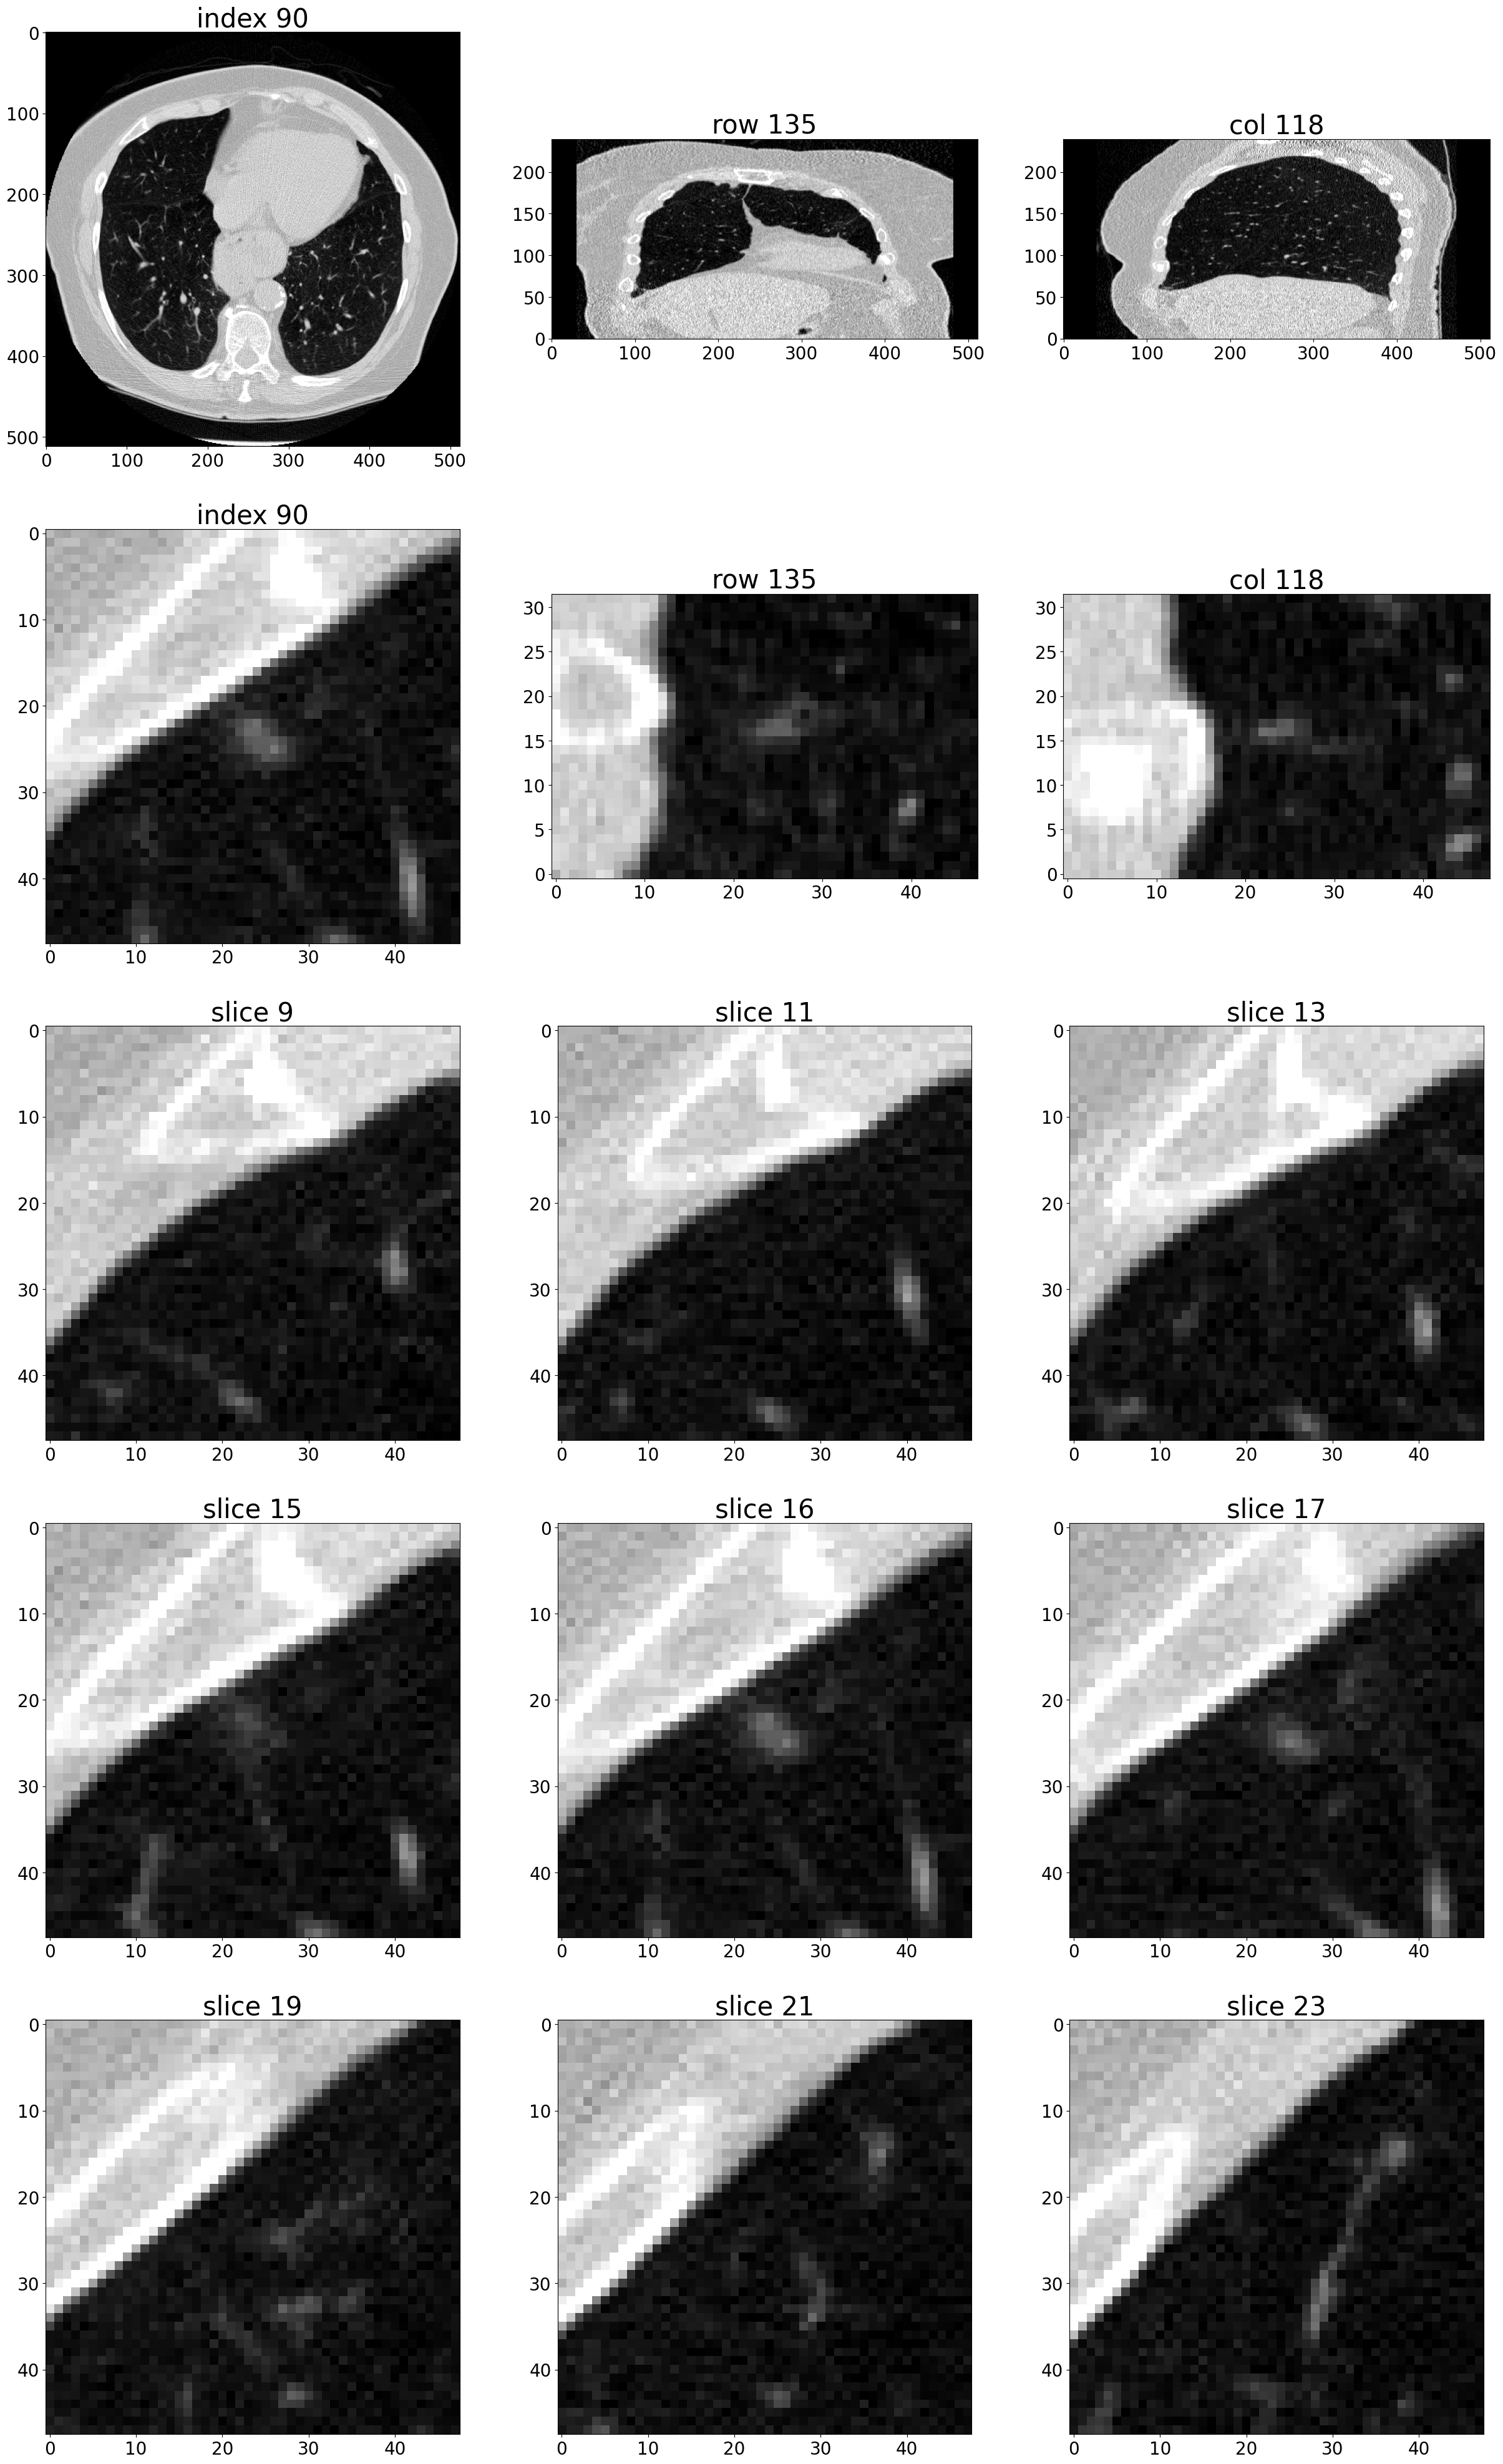

In [105]:
series_uid = '1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591'
showCandidate(series_uid)

# Model

In [28]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader

In [29]:
class LunaBlock(nn.Module):
    def __init__(self, in_channels, conv_channels):
        super().__init__()
        
        self.conv1 = nn.Conv3d(in_channels, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(conv_channels, conv_channels, kernel_size=3, padding=1, bias=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(2, 2)
        
    def forward(self, input_batch):
        block_out = self.conv1(input_batch)
        block_out = self.relu1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.relu2(block_out) 
        
        return self.maxpool(block_out)

In [30]:
class LunaModel(nn.Module):
    def __init__(self, in_channels=1, conv_channels=8):
        super().__init__()
        
        # tail
        self.tail_batchnorm = nn.BatchNorm3d(1)
        
        # body
        self.block1 = LunaBlock(in_channels, conv_channels)
        self.block2 = LunaBlock(conv_channels, conv_channels * 2)
        self.block3 = LunaBlock(conv_channels * 2, conv_channels * 4)
        self.block4 = LunaBlock(conv_channels * 4, conv_channels * 8)
        
        # head
        self.head_linear = nn.Linear(1152, 2)
        self.head_softmax = nn.Softmax(dim=1)
        
        self._init_weights()
    
    def forward(self, input_batch):
        bn_output = self.tail_batchnorm(input_batch)
        
        block_output = self.block1(bn_output)
        block_output = self.block2(block_output)
        block_output = self.block3(block_output)
        block_output = self.block4(block_output)
        
        conv_flat = block_output.view(block_output.size(0), -1)
        
        linear_output = self.head_linear(conv_flat)
        return linear_output, self.head_softmax(linear_output)
    
    # see also https://github.com/pytorch/pytorch/issues/18182
    def _init_weights(self):
        for m in self.modules():
            if type(m) in {
                nn.Linear,
                nn.Conv3d,
                nn.Conv2d,
                nn.ConvTranspose2d,
                nn.ConvTranspose3d,
            }:
                nn.init.kaiming_normal_(
                    m.weight.data, a=0, mode='fan_out', nonlinearity='relu',
                )
                if m.bias is not None:
                    fan_in, fan_out = \
                        nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                    bound = 1 / math.sqrt(fan_out)
                    nn.init.normal_(m.bias, -bound, bound)
        

In [31]:
# From https://github.com/jvanvugt/pytorch-unet
# https://raw.githubusercontent.com/jvanvugt/pytorch-unet/master/unet.py

# MIT License
#
# Copyright (c) 2018 Joris
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Adapted from https://discuss.pytorch.org/t/unet-implementation/426

import torch
from torch import nn
import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self, in_channels=1, n_classes=2, depth=5, wf=6, padding=False,
                 batch_norm=False, up_mode='upconv'):
        """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597

        Using the default arguments will yield the exact version used
        in the original paper

        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
        """
        super(UNet, self).__init__()
        assert up_mode in ('upconv', 'upsample')
        self.padding = padding
        self.depth = depth
        prev_channels = in_channels
        self.down_path = nn.ModuleList()
        for i in range(depth):
            self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i),
                                                padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.up_path = nn.ModuleList()
        for i in reversed(range(depth - 1)):
            self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode,
                                            padding, batch_norm))
            prev_channels = 2**(wf+i)

        self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)

    def forward(self, x):
        blocks = []
        for i, down in enumerate(self.down_path):
            x = down(x)
            if i != len(self.down_path)-1:
                blocks.append(x)
                x = F.avg_pool2d(x, 2)

        for i, up in enumerate(self.up_path):
            x = up(x, blocks[-i-1])

        return self.last(x)


class UNetConvBlock(nn.Module):
    def __init__(self, in_size, out_size, padding, batch_norm):
        super(UNetConvBlock, self).__init__()
        block = []

        block.append(nn.Conv2d(in_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        # block.append(nn.LeakyReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        block.append(nn.Conv2d(out_size, out_size, kernel_size=3,
                               padding=int(padding)))
        block.append(nn.ReLU())
        # block.append(nn.LeakyReLU())
        if batch_norm:
            block.append(nn.BatchNorm2d(out_size))

        self.block = nn.Sequential(*block)

    def forward(self, x):
        out = self.block(x)
        return out


class UNetUpBlock(nn.Module):
    def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
        super(UNetUpBlock, self).__init__()
        if up_mode == 'upconv':
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2,
                                         stride=2)
        elif up_mode == 'upsample':
            self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                                    nn.Conv2d(in_size, out_size, kernel_size=1))

        self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)

    def center_crop(self, layer, target_size):
        _, _, layer_height, layer_width = layer.size()
        diff_y = (layer_height - target_size[0]) // 2
        diff_x = (layer_width - target_size[1]) // 2
        return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]

    def forward(self, x, bridge):
        up = self.up(x)
        crop1 = self.center_crop(bridge, up.shape[2:])
        out = torch.cat([up, crop1], 1)
        out = self.conv_block(out)

        return out


In [32]:
class UNetWrapper(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        
        self.input_batchnorm = nn.BatchNorm2d(kwargs['in_channels'])
        self.unet = UNet(**kwargs)
        self.final = nn.Sigmoid()
        
        self._init_weights()
        
    def _init_weights(self):
        init_set = {
            nn.Conv2d,
            nn.Conv3d,
            nn.ConvTranspose2d,
            nn.ConvTranspose3d,
            nn.Linear,
        }
        for m in self.modules():
            if type(m) in init_set:
                nn.init.kaiming_normal_(
                    m.weight.data, mode='fan_out', nonlinearity='relu', a=0
                )
                if m.bias is not None:
                    fan_in, fan_out = \
                        nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                    bound = 1 / math.sqrt(fan_out)
                    nn.init.normal_(m.bias, -bound, bound)
                    
    def forward(self, input_batch):
        bn_output = self.input_batchnorm(input_batch)
        un_output = self.unet(bn_output)
        fn_output = self.final(un_output)
        return fn_output

# Prepaire Catch

In [33]:
class LunaPrepCacheApp:
    @classmethod
    def __init__(self, sys_argv=None):
        if sys_argv is None:
            sys_argv = sys.argv[1:]

    def main(self):
        log.info("Starting {}".format(type(self).__name__))

        self.prep_dl = DataLoader(
            LunaDataset(
                val_stride=10,
                sortby_str='series_uid',
                isValSet_bool=True,
            ),
            batch_size=1024,
            num_workers=4,
        )

        batch_iter = enumerateWithEstimate(
            self.prep_dl,
            "Stuffing cache",
            start_ndx=4,
        )
        for batch_ndx, batch_tup in batch_iter:
            pass
        
        for _ in batch_iter:
            pass

In [34]:
pre = LunaPrepCacheApp()

In [35]:
pre.main()

2024-07-06 07:49:42,573 INFO     pid:34 __main__:008:main Starting LunaPrepCacheApp
2024-07-06 07:49:42,719 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7874b932e260>: 30136 validation samples, 30064 neg, 72 pos, unbalanced ratio
2024-07-06 07:49:42,720 WARNING  pid:34 __main__:081:enumerateWithEstimate Stuffing cache ----/30, starting
2024-07-06 07:50:54,373 INFO     pid:34 __main__:098:enumerateWithEstimate Stuffing cache    8/30, done at 2024-07-06 07:53:38, 0:03:23
2024-07-06 07:51:34,453 INFO     pid:34 __main__:098:enumerateWithEstimate Stuffing cache   16/30, done at 2024-07-06 07:52:53, 0:02:38
2024-07-06 07:52:38,275 WARNING  pid:34 __main__:111:enumerateWithEstimate Stuffing cache ----/30, done at 2024-07-06 07:52:38


# Analysis Process

In [36]:
import argparse
import os
import shutil

import scipy.ndimage.measurements as measurements
import scipy.ndimage.morphology as morphology

from torch.utils.tensorboard import SummaryWriter

METRICS_SIZE = 10

METRICS_LABEL_NDX=0
METRICS_PRED_NDX=1
METRICS_LOSS_NDX=2
METRICS_SIZE = 3

2024-07-06 08:01:01.361664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 08:01:01.361758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 08:01:01.506508: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-06 08:01:10,526 INFO     pid:34 numexpr.utils:161:_init_num_threads NumExpr defaulting to 4 threads.


In [38]:
def print_confusion(label, confusions, do_mal):
    row_labels = ['Non-Nodules', 'Benign', 'Malignant']

    if do_mal:
        col_labels = ['', 'Complete Miss', 'Filtered Out', 'Pred. Benign', 'Pred. Malignant']
    else:
        col_labels = ['', 'Complete Miss', 'Filtered Out', 'Pred. Nodule']
        confusions[:, -2] += confusions[:, -1]
        confusions = confusions[:, :-1]
    cell_width = 16
    f = '{:>' + str(cell_width) + '}'
    print(label)
    print(' | '.join([f.format(s) for s in col_labels]))
    for i, (l, r) in enumerate(zip(row_labels, confusions)):
        r = [l] + list(r)
        if i == 0:
            r[1] = ''
        print(' | '.join([f.format(i) for i in r]))

In [39]:
def match_and_score(detections, truth, threshold=0.5, threshold_mal=0.5):
    # Returns 3x4 confusion matrix for:
    # Rows: Truth: Non-Nodules, Benign, Malignant
    # Cols: Not Detected, Detected by Seg, Detected as Benign, Detected as Malignant
    # If one true nodule matches multiple detections, the "highest" detection is considered
    # If one detection matches several true nodule annotations, it counts for all of them
    true_nodules = [c for c in truth if c.isNodule_bool]
    truth_diams = np.array([c.diameter_mm for c in true_nodules])
    truth_xyz = np.array([c.center_xyz for c in true_nodules])

    detected_xyz = np.array([n[2] for n in detections])
    # detection classes will contain
    # 1 -> detected by seg but filtered by cls
    # 2 -> detected as benign nodule (or nodule if no malignancy model is used)
    # 3 -> detected as malignant nodule (if applicable)
    detected_classes = np.array([1 if d[0] < threshold
                                 else (2 if d[1] < threshold
                                       else 3) for d in detections])

    confusion = np.zeros((3, 4), dtype=np.int_)
    if len(detected_xyz) == 0:
        for tn in true_nodules:
            confusion[2 if tn.isMal_bool else 1, 0] += 1
    elif len(truth_xyz) == 0:
        for dc in detected_classes:
            confusion[0, dc] += 1
    else:
        normalized_dists = np.linalg.norm(truth_xyz[:, None] - detected_xyz[None], ord=2, axis=-1) / truth_diams[:, None]
        matches = (normalized_dists < 0.7)
        unmatched_detections = np.ones(len(detections), dtype=np.bool_)
        matched_true_nodules = np.zeros(len(true_nodules), dtype=np.int_)
        for i_tn, i_detection in zip(*matches.nonzero()):
            matched_true_nodules[i_tn] = max(matched_true_nodules[i_tn], detected_classes[i_detection])
            unmatched_detections[i_detection] = False

        for ud, dc in zip(unmatched_detections, detected_classes):
            if ud:
                confusion[0, dc] += 1
        for tn, dc in zip(true_nodules, matched_true_nodules):
            confusion[2 if tn.isMal_bool else 1, dc] += 1
    return confusion

In [60]:
class NoduleAnalysisApp:
    def __init__(self, sys_argv=None):
        if sys_argv is None:
            log.debug(sys.argv)
            sys_argv = sys.argv[1:]

        parser = argparse.ArgumentParser()
        parser.add_argument('--batch-size',
            help='Batch size to use for training',
            default=4,
            type=int,
        )
        parser.add_argument('--num-workers',
            help='Number of worker processes for background data loading',
            default=4,
            type=int,
        )

        parser.add_argument('--run-validation',
            help='Run over validation rather than a single CT.',
            action='store_true',
            default=False,
        )
        parser.add_argument('--include-train',
            help="Include data that was in the training set. (default: validation data only)",
            action='store_true',
            default=False,
        )

        parser.add_argument('--segmentation-path',
            help="Path to the saved segmentation model",
            nargs='?',
            default='data/part2/models/seg_2020-01-26_19.45.12_w4d3c1-bal_1_nodupe-label_pos-d1_fn8-adam.best.state',
        )

        parser.add_argument('--cls-model',
            help="What to model class name to use for the classifier.",
            action='store',
            default='LunaModel',
        )
        parser.add_argument('--classification-path',
            help="Path to the saved classification model",
            nargs='?',
            default='data/part2/models/cls_2020-02-06_14.16.55_final-nodule-nonnodule.best.state',
        )

        parser.add_argument('--malignancy-model',
            help="What to model class name to use for the malignancy classifier.",
            action='store',
            default='LunaModel',
            # default='ModifiedLunaModel',
        )
        parser.add_argument('--malignancy-path',
            help="Path to the saved malignancy classification model",
            nargs='?',
            default=None,
        )

        parser.add_argument('--tb-prefix',
            default='analyz',
            help="Data prefix to use for Tensorboard run. Defaults to chapter.",
        )

        parser.add_argument('series_uid',
            nargs='?',
            default=None,
            help="Series UID to use.",
        )

        self.cli_args = parser.parse_args(sys_argv)
        # self.time_str = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

        if not (bool(self.cli_args.series_uid) ^ self.cli_args.run_validation):
            raise Exception("One and only one of series_uid and --run-validation should be given")


        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")

        self.seg_model, self.cls_model, self.malignancy_model = self.initModels()


    def initModels(self):
        log.debug(self.cli_args.segmentation_path)
        seg_dict = torch.load(self.cli_args.segmentation_path, map_location=torch.device('cpu'))

        seg_model = UNetWrapper(
            in_channels=7,
            n_classes=1,
            depth=3,
            wf=4,
            padding=True,
            batch_norm=True,
            up_mode='upconv',
        )
        
        seg_model.load_state_dict(seg_dict['model_state'])
        seg_model.eval()

        log.debug(self.cli_args.classification_path)
        cls_dict = torch.load(self.cli_args.classification_path, map_location=torch.device('cpu'))
        cls_model = LunaModel()
        cls_model.load_state_dict(cls_dict['model_state'])
        cls_model.eval()

        if self.use_cuda:
            if torch.cuda.device_count() > 1:
                seg_model = nn.DataParallel(seg_model)
                cls_model = nn.DataParallel(cls_model)

            seg_model.to(self.device)
            cls_model.to(self.device)

        if self.cli_args.malignancy_path:
            malignancy_model = LunaModel()
            malignancy_dict = torch.load(self.cli_args.malignancy_path, map_location=torch.device('cpu'))
            malignancy_model.load_state_dict(malignancy_dict['model_state'])
            malignancy_model.eval()
            if self.use_cuda:
                malignancy_model.to(self.device)
        else:
            malignancy_model = None
        return seg_model, cls_model, malignancy_model


    def initSegmentationDl(self, series_uid):
        seg_ds = Luna2dSegmentationDataset(
                contextSlices_count=3,
                series_uid=series_uid,
                fullCt_bool=True,
            )
        seg_dl = DataLoader(
            seg_ds,
            batch_size=self.cli_args.batch_size * (torch.cuda.device_count() if self.use_cuda else 1),
            num_workers=self.cli_args.num_workers,
            pin_memory=self.use_cuda,
        )

        return seg_dl

    def initClassificationDl(self, candidateInfo_list):
        cls_ds = LunaDataset(
                sortby_str='series_uid',
                candidateInfo_list=candidateInfo_list,
            )
        cls_dl = DataLoader(
            cls_ds,
            batch_size=self.cli_args.batch_size * (torch.cuda.device_count() if self.use_cuda else 1),
            num_workers=self.cli_args.num_workers,
            pin_memory=self.use_cuda,
        )

        return cls_dl


    def main(self):
        log.info("Starting {}, {}".format(type(self).__name__, self.cli_args))

        val_ds = LunaDataset(
            val_stride=10,
            isValSet_bool=True,
        )
        val_set = set(
            candidateInfo_tup.series_uid
            for candidateInfo_tup in val_ds.candidateInfo_list
        )
        positive_set = set(
            candidateInfo_tup.series_uid
            for candidateInfo_tup in getCandidateInfoList()
            if candidateInfo_tup.isNodule_bool
        )
        
        if self.cli_args.series_uid:
            series_set = set(self.cli_args.series_uid.split(','))
            print(series_set)
        else:
            series_set = set(
                candidateInfo_tup.series_uid
                for candidateInfo_tup in getCandidateInfoList()
            )
                    
        if self.cli_args.include_train:
            train_list = sorted(series_set - val_set)
        else:
            train_list = []
        val_list = sorted(series_set & val_set)
        
        candidateInfo_dict = getCandidateInfoDict()
        series_iter = enumerateWithEstimate(
            val_list + train_list,
            "Series",
        )
        all_confusion = np.zeros((3, 4), dtype=np.int_)
        for _, series_uid in series_iter:
            ct = getCt(series_uid)
            mask_a = self.segmentCt(ct, series_uid)

            candidateInfo_list = self.groupSegmentationOutput(
                series_uid, ct, mask_a)
            classifications_list = self.classifyCandidates(
                ct, candidateInfo_list)

            if not self.cli_args.run_validation:
                print(f"found nodule candidates in {series_uid}:")
                for prob, prob_mal, center_xyz, center_irc in classifications_list:
                    if prob > 0.5:
                        s = f"nodule prob {prob:.3f}, "
                        if self.malignancy_model:
                            s += f"malignancy prob {prob_mal:.3f}, "
                        s += f"center xyz {center_xyz}"
                        print(s)

            if series_uid in candidateInfo_dict:
                one_confusion = match_and_score(
                    classifications_list, candidateInfo_dict[series_uid]
                )
                all_confusion += one_confusion
                print_confusion(
                    series_uid, one_confusion, self.malignancy_model is not None
                )

        print_confusion(
            "Total", all_confusion, self.malignancy_model is not None
        )


    def classifyCandidates(self, ct, candidateInfo_list):
        cls_dl = self.initClassificationDl(candidateInfo_list)
        classifications_list = []
        for batch_ndx, batch_tup in enumerate(cls_dl):
            input_t, _, _, series_list, center_list = batch_tup

            input_g = input_t.to(self.device)
            with torch.no_grad():
                _, probability_nodule_g = self.cls_model(input_g)
                if self.malignancy_model is not None:
                    _, probability_mal_g = self.malignancy_model(input_g)
                else:
                    probability_mal_g = torch.zeros_like(probability_nodule_g)

            zip_iter = zip(center_list,
                probability_nodule_g[:,1].tolist(),
                probability_mal_g[:,1].tolist())
            for center_irc, prob_nodule, prob_mal in zip_iter:
                center_xyz = irc2xyz(center_irc,
                    direction_a=ct.direction_a,
                    origin_xyz=ct.origin_xyz,
                    vxSize_xyz=ct.vxSize_xyz,
                )
                cls_tup = (prob_nodule, prob_mal, center_xyz, center_irc)
                classifications_list.append(cls_tup)
        return classifications_list

    def segmentCt(self, ct, series_uid):
        with torch.no_grad():
            output_a = np.zeros_like(ct.hu_a, dtype=np.float32)
            seg_dl = self.initSegmentationDl(series_uid)  #  <3>
            for input_t, _, _, slice_ndx_list in seg_dl:

                input_g = input_t.to(self.device)
                prediction_g = self.seg_model(input_g)

                for i, slice_ndx in enumerate(slice_ndx_list):
                    output_a[slice_ndx] = prediction_g[i].cpu().numpy()

            mask_a = output_a > 0.5
            mask_a = morphology.binary_erosion(mask_a, iterations=1)

        return mask_a

    def groupSegmentationOutput(self, series_uid,  ct, clean_a):
        candidateLabel_a, candidate_count = measurements.label(clean_a)
        centerIrc_list = measurements.center_of_mass(
            ct.hu_a.clip(-1000, 1000) + 1001,
            labels=candidateLabel_a,
            index=np.arange(1, candidate_count+1),
        )

        candidateInfo_list = []
        for i, center_irc in enumerate(centerIrc_list):
            center_xyz = irc2xyz(
                center_irc,
                ct.origin_xyz,
                ct.vxSize_xyz,
                ct.direction_a,
            )
            assert np.all(np.isfinite(center_irc)), repr(['irc', center_irc, i, candidate_count])
            assert np.all(np.isfinite(center_xyz)), repr(['xyz', center_xyz])
            candidateInfo_tup = \
                CandidateInfoTuple(False, False, False, 0.0, series_uid, center_xyz)
            candidateInfo_list.append(candidateInfo_tup)

        return candidateInfo_list

    def logResults(self, mode_str, filtered_list, series2diagnosis_dict, positive_set):
        count_dict = {'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}
        for series_uid in filtered_list:
            probablity_float, center_irc = series2diagnosis_dict.get(series_uid, (0.0, None))
            if center_irc is not None:
                center_irc = tuple(int(x.item()) for x in center_irc)
            positive_bool = series_uid in positive_set
            prediction_bool = probablity_float > 0.5
            correct_bool = positive_bool == prediction_bool

            if positive_bool and prediction_bool:
                count_dict['tp'] += 1
            if not positive_bool and not prediction_bool:
                count_dict['tn'] += 1
            if not positive_bool and prediction_bool:
                count_dict['fp'] += 1
            if positive_bool and not prediction_bool:
                count_dict['fn'] += 1


            log.info("{} {} Label:{!r:5} Pred:{!r:5} Correct?:{!r:5} Value:{:.4f} {}".format(
                mode_str,
                series_uid,
                positive_bool,
                prediction_bool,
                correct_bool,
                probablity_float,
                center_irc,
            ))

        total_count = sum(count_dict.values())
        percent_dict = {k: v / (total_count or 1) * 100 for k, v in count_dict.items()}

        precision = percent_dict['p'] = count_dict['tp'] / ((count_dict['tp'] + count_dict['fp']) or 1)
        recall    = percent_dict['r'] = count_dict['tp'] / ((count_dict['tp'] + count_dict['fn']) or 1)
        percent_dict['f1'] = 2 * (precision * recall) / ((precision + recall) or 1)

        log.info(mode_str + " tp:{tp:.1f}%, tn:{tn:.1f}%, fp:{fp:.1f}%, fn:{fn:.1f}%".format(
            **percent_dict,
        ))
        log.info(mode_str + " precision:{p:.3f}, recall:{r:.3f}, F1:{f1:.3f}".format(
            **percent_dict,
        ))

# Start Training

### Predict 1 (mel.dep_2.best model)

In [61]:
app = NoduleAnalysisApp([
    '--run-validation',
    '--segmentation-path', '/kaggle/input/seg-cls-model/seg_2024-07-05_05.59.19_none.100000.state',
    '--classification-path', '/kaggle/input/seg-cls-model/Nodule_Detect_model_last.state',
    '--malignancy-path', '/kaggle/input/mal-model/cls_2024-07-06_06.02.57_dlwpt.dep_2.best.state'
])

In [62]:
app.device

device(type='cuda')

In [63]:
app.main()

2024-07-06 08:18:43,156 INFO     pid:34 __main__:157:main Starting NoduleAnalysisApp, Namespace(batch_size=4, num_workers=4, run_validation=True, include_train=False, segmentation_path='/kaggle/input/seg-cls-model/seg_2024-07-05_05.59.19_none.100000.state', cls_model='LunaModel', classification_path='/kaggle/input/seg-cls-model/Nodule_Detect_model_last.state', malignancy_model='LunaModel', malignancy_path='/kaggle/input/mal-model/cls_2024-07-06_06.02.57_dlwpt.dep_2.best.state', tb_prefix='analyz', series_uid=None)
2024-07-06 08:18:43,339 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734d7f3f70>: 30136 validation samples, 30064 neg, 72 pos, unbalanced ratio
2024-07-06 08:18:43,426 WARNING  pid:34 __main__:081:enumerateWithEstimate Series ----/52, starting
2024-07-06 08:18:44,187 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734e29ceb0>: 1 general series, 481 slices, 0 nodules
/tmp/ipykernel_34/4059826098.py:272: Depre

1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1393 |               16 |                6
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:19:45,076 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734f32f160>: 1 general series, 280 slices, 1 nodules
2024-07-06 08:19:58,364 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f3288e0>: 1633 training samples, 1633 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1619 |                9 |                4
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:20:13,058 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734e29f520>: 1 general series, 633 slices, 1 nodules
2024-07-06 08:21:45,369 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734e29ceb0>: 3432 training samples, 3432 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             3333 |               61 |               31
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:22:17,229 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f922d870>: 1 general series, 548 slices, 1 nodules
2024-07-06 08:22:35,974 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734e29ceb0>: 1611 training samples, 1611 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1570 |               28 |               12
          Benign |                0 |                0 |                0 |                1
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:22:50,289 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734f34fc10>: 1 general series, 128 slices, 6 nodules
2024-07-06 08:22:55,190 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f922d870>: 882 training samples, 882 neg, 0 pos, unbalanced ratio
2024-07-06 08:23:02,397 INFO     pid:34 __main__:098:enumerateWithEstimate Series    4/52, done at 2024-07-06 09:03:36, 0:44:53


1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048856168343065566972
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              865 |                9 |                4
          Benign |                2 |                0 |                4 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:23:04,181 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734e29ceb0>: 1 general series, 197 slices, 1 nodules
2024-07-06 08:23:11,480 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f922c070>: 1503 training samples, 1503 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.127965161564033605177803085629
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1464 |               29 |               10
          Benign |                0 |                0 |                0 |                0
       Malignant |                1 |                0 |                0 |                0


2024-07-06 08:23:25,659 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78735d442470>: 1 general series, 202 slices, 2 nodules
2024-07-06 08:23:33,154 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78735d443f70>: 1434 training samples, 1434 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1416 |               10 |                6
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:23:48,436 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734e29f520>: 1 general series, 456 slices, 0 nodules
2024-07-06 08:24:04,317 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78735d442470>: 2174 training samples, 2174 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             2120 |               35 |               19
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:24:23,562 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734e29ceb0>: 1 general series, 133 slices, 0 nodules
2024-07-06 08:24:28,555 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78735d443f70>: 786 training samples, 786 neg, 0 pos, unbalanced ratio
2024-07-06 08:24:35,007 INFO     pid:34 __main__:098:enumerateWithEstimate Series    8/52, done at 2024-07-06 08:52:34, 0:33:51


1.3.6.1.4.1.14519.5.2.1.6279.6001.143410010885830403003179808334
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              779 |                6 |                1
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:24:36,151 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734e29f520>: 1 general series, 132 slices, 0 nodules
2024-07-06 08:24:41,071 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78735d441f90>: 1084 training samples, 1084 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1073 |                7 |                4
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:24:52,284 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78735d442470>: 1 general series, 301 slices, 3 nodules
2024-07-06 08:25:03,121 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734e29f520>: 1341 training samples, 1341 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1308 |               16 |               14
          Benign |                0 |                0 |                3 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:25:15,087 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78735d441f90>: 1 general series, 133 slices, 0 nodules
2024-07-06 08:25:20,029 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734e29f520>: 644 training samples, 644 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              629 |               10 |                5
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:25:27,666 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78735d441f90>: 1 general series, 260 slices, 1 nodules
2024-07-06 08:25:36,820 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f922d870>: 1738 training samples, 1738 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.163994693532965040247348251579
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1710 |               18 |                9
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:25:54,725 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f922d870>: 1 general series, 538 slices, 3 nodules
2024-07-06 08:26:13,262 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78735d441f90>: 1809 training samples, 1809 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1772 |               28 |                6
          Benign |                0 |                0 |                2 |                0
       Malignant |                0 |                0 |                1 |                0


2024-07-06 08:26:29,123 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734e29f520>: 1 general series, 133 slices, 1 nodules
2024-07-06 08:26:34,208 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734e29ceb0>: 746 training samples, 746 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              736 |                9 |                0
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:26:42,545 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78735d442470>: 1 general series, 270 slices, 1 nodules
2024-07-06 08:26:51,978 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734e29ceb0>: 910 training samples, 910 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.184412674007117333405073397832
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              889 |               20 |                0
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:27:02,163 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f922d870>: 1 general series, 251 slices, 2 nodules
2024-07-06 08:27:10,974 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734e29ceb0>: 849 training samples, 849 neg, 0 pos, unbalanced ratio
2024-07-06 08:27:18,102 INFO     pid:34 __main__:098:enumerateWithEstimate Series   16/52, done at 2024-07-06 08:44:57, 0:26:14


1.3.6.1.4.1.14519.5.2.1.6279.6001.189483585244687808087477024767
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              823 |               20 |                5
          Benign |                1 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:27:19,320 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734e29f520>: 1 general series, 137 slices, 1 nodules
2024-07-06 08:27:24,456 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78735d441f90>: 785 training samples, 785 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              760 |               13 |               11
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:27:33,214 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78735d441f90>: 1 general series, 240 slices, 2 nodules
2024-07-06 08:27:41,747 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78735d443f70>: 1343 training samples, 1343 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1320 |               21 |                2
          Benign |                1 |                0 |                0 |                0
       Malignant |                1 |                0 |                0 |                0


2024-07-06 08:27:54,729 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7874b91b50c0>: 1 general series, 133 slices, 1 nodules
2024-07-06 08:27:59,746 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7874b91b50c0>: 683 training samples, 683 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              658 |               18 |                5
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:28:09,411 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fbd89f30>: 1 general series, 481 slices, 2 nodules
2024-07-06 08:28:25,714 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734669ff40>: 1374 training samples, 1374 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.208511362832825683639135205368
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1335 |               31 |                3
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                2


2024-07-06 08:28:39,086 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7874b91b5120>: 1 general series, 276 slices, 3 nodules
2024-07-06 08:28:48,784 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f96bd8a0>: 1423 training samples, 1423 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1380 |               33 |                7
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                2


2024-07-06 08:29:01,648 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734669ff40>: 1 general series, 247 slices, 2 nodules
2024-07-06 08:29:10,330 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f96bd8a0>: 1523 training samples, 1523 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.218476624578721885561483687176
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1496 |               22 |                3
          Benign |                0 |                0 |                2 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:29:25,106 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fbd89b40>: 1 general series, 286 slices, 4 nodules
2024-07-06 08:29:35,061 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734669ff40>: 1562 training samples, 1562 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.224465398054769500989828256685
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1491 |               63 |                6
          Benign |                1 |                0 |                2 |                0
       Malignant |                1 |                0 |                0 |                0


2024-07-06 08:29:51,651 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f88250>: 1 general series, 509 slices, 0 nodules
2024-07-06 08:30:08,673 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f324160>: 1564 training samples, 1564 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1545 |               14 |                5
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:30:23,766 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f96bd8a0>: 1 general series, 246 slices, 1 nodules
2024-07-06 08:30:32,364 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734669ff40>: 1408 training samples, 1408 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1375 |               28 |                5
          Benign |                0 |                0 |                0 |                0
       Malignant |                1 |                0 |                0 |                0


2024-07-06 08:30:46,850 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fdceb670>: 1 general series, 425 slices, 1 nodules
2024-07-06 08:31:01,258 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fdceb670>: 2350 training samples, 2350 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.244442540088515471945035689377
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             2287 |               46 |               17
          Benign |                1 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:31:23,654 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f96bcac0>: 1 general series, 481 slices, 3 nodules
2024-07-06 08:31:39,889 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f96bcac0>: 2068 training samples, 2068 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             2030 |               32 |                4
          Benign |                0 |                0 |                1 |                1
       Malignant |                1 |                0 |                0 |                0


2024-07-06 08:31:57,910 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fd095840>: 1 general series, 137 slices, 1 nodules
2024-07-06 08:32:02,974 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f96bcac0>: 722 training samples, 722 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.255999614855292116767517149228
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              708 |               12 |                1
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:32:11,423 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f6b160>: 1 general series, 413 slices, 0 nodules
2024-07-06 08:32:25,364 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fd095840>: 1691 training samples, 1691 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1652 |               37 |                2
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:32:40,108 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f6b160>: 1 general series, 123 slices, 0 nodules
2024-07-06 08:32:44,651 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fd095840>: 916 training samples, 916 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              904 |               10 |                2
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:32:54,163 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78740593c8b0>: 1 general series, 209 slices, 3 nodules
2024-07-06 08:33:01,644 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873466cbe20>: 1275 training samples, 1275 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.275007193025729362844652516689
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1206 |               44 |               16
          Benign |                1 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                2


2024-07-06 08:33:14,440 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f6b160>: 1 general series, 334 slices, 7 nodules
2024-07-06 08:33:25,798 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404a179a0>: 1062 training samples, 1062 neg, 0 pos, unbalanced ratio
2024-07-06 08:33:34,272 INFO     pid:34 __main__:098:enumerateWithEstimate Series   32/52, done at 2024-07-06 08:42:07, 0:23:23


1.3.6.1.4.1.14519.5.2.1.6279.6001.280072876841890439628529365478
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1032 |               13 |                8
          Benign |                0 |                0 |                3 |                0
       Malignant |                1 |                0 |                1 |                2


2024-07-06 08:33:35,354 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873466cbe20>: 1 general series, 123 slices, 5 nodules
2024-07-06 08:33:40,059 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404a179a0>: 831 training samples, 831 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              809 |               17 |                2
          Benign |                1 |                0 |                1 |                1
       Malignant |                1 |                0 |                0 |                1


2024-07-06 08:33:47,601 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734669ff40>: 1 general series, 133 slices, 0 nodules
2024-07-06 08:33:52,481 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873466cbe20>: 685 training samples, 685 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932699509516219450076
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              640 |               27 |               18
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:33:59,292 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f6b160>: 1 general series, 122 slices, 0 nodules
2024-07-06 08:34:03,819 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787405c13f10>: 999 training samples, 999 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              993 |                5 |                1
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:34:13,347 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734f324160>: 1 general series, 201 slices, 0 nodules
2024-07-06 08:34:20,404 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f4c4c0>: 836 training samples, 836 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              829 |                6 |                1
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:34:30,693 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787405c13f10>: 1 general series, 465 slices, 1 nodules
2024-07-06 08:34:46,300 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f4c4c0>: 1560 training samples, 1560 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1528 |               18 |               11
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:35:00,521 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787405c13f10>: 1 general series, 180 slices, 1 nodules
2024-07-06 08:35:07,015 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f6b160>: 1111 training samples, 1111 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.321465552859463184018938648244
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1079 |               20 |               11
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:35:17,422 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787405c13f10>: 1 general series, 145 slices, 0 nodules
2024-07-06 08:35:22,766 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873466cbe20>: 868 training samples, 868 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              858 |                8 |                2
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:35:34,772 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787405c13f10>: 1 general series, 261 slices, 1 nodules
2024-07-06 08:35:43,938 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404a179a0>: 1734 training samples, 1734 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.334105754605642100456249422350
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1697 |               30 |                6
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:36:01,746 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f881c0>: 1 general series, 131 slices, 1 nodules
2024-07-06 08:36:06,878 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f324160>: 967 training samples, 967 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              955 |                8 |                2
          Benign |                0 |                0 |                0 |                1
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:36:15,327 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f88250>: 1 general series, 214 slices, 0 nodules
2024-07-06 08:36:22,925 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f88220>: 966 training samples, 966 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.397202838387416555106806022938
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              953 |               10 |                3
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:36:33,019 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734f34e080>: 1 general series, 142 slices, 2 nodules
2024-07-06 08:36:38,481 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787405c13f10>: 649 training samples, 649 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.438308540025607517017949816111
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              642 |                3 |                2
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:36:46,286 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fd095840>: 1 general series, 297 slices, 2 nodules
2024-07-06 08:36:56,477 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fd096c80>: 1573 training samples, 1573 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1513 |               37 |               21
          Benign |                0 |                0 |                2 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:37:09,966 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fd095840>: 1 general series, 127 slices, 0 nodules
2024-07-06 08:37:14,639 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f324160>: 997 training samples, 997 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              989 |                6 |                2
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:37:23,765 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f8f404f0>: 1 general series, 261 slices, 0 nodules
2024-07-06 08:37:32,767 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404a179a0>: 1270 training samples, 1270 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1252 |               15 |                3
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:37:44,050 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404a179a0>: 1 general series, 129 slices, 0 nodules
2024-07-06 08:37:48,890 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404a179a0>: 621 training samples, 621 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.669518152156802508672627785405
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              620 |                1 |                0
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:37:55,030 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f63e74c0>: 1 general series, 278 slices, 1 nodules
2024-07-06 08:38:04,863 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f8f404f0>: 1909 training samples, 1909 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1857 |               36 |               10
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:38:21,615 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734d7f03a0>: 1 general series, 244 slices, 1 nodules
2024-07-06 08:38:30,212 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734d7f03a0>: 1349 training samples, 1349 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1303 |               39 |                6
          Benign |                0 |                0 |                0 |                1
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:38:41,801 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734d7f22c0>: 1 general series, 119 slices, 1 nodules
2024-07-06 08:38:46,343 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404a179a0>: 674 training samples, 674 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.861997885565255340442123234170
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              652 |               20 |                2
          Benign |                1 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:38:52,829 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fdce9e70>: 1 general series, 238 slices, 2 nodules
2024-07-06 08:39:01,299 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f6b160>: 1134 training samples, 1134 neg, 0 pos, unbalanced ratio
2024-07-06 08:39:10,457 WARNING  pid:34 __main__:111:enumerateWithEstimate Series ----/52, done at 2024-07-06 08:39:10


1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293840351008008793409
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1108 |               19 |                4
          Benign |                0 |                0 |                0 |                1
       Malignant |                0 |                0 |                0 |                1
Total
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |            64955 |             1093 |              340
          Benign |                9 |                0 |               29 |                6
       Malignant |                7 |                0 |                2 |               19


### Predict 2 (mel.dep_2.1000000 model)

In [64]:
app2 = NoduleAnalysisApp([
    '--run-validation',
    '--segmentation-path', '/kaggle/input/seg-cls-model/seg_2024-07-05_05.59.19_none.100000.state',
    '--classification-path', '/kaggle/input/seg-cls-model/Nodule_Detect_model_last.state',
    '--malignancy-path', '/kaggle/input/mal-model/cls_2024-07-06_06.02.57_dlwpt.dep_2.1000000.state'
])

In [65]:
app2.device

device(type='cuda')

In [66]:
app2.main()

2024-07-06 08:44:34,041 INFO     pid:34 __main__:157:main Starting NoduleAnalysisApp, Namespace(batch_size=4, num_workers=4, run_validation=True, include_train=False, segmentation_path='/kaggle/input/seg-cls-model/seg_2024-07-05_05.59.19_none.100000.state', cls_model='LunaModel', classification_path='/kaggle/input/seg-cls-model/Nodule_Detect_model_last.state', malignancy_model='LunaModel', malignancy_path='/kaggle/input/mal-model/cls_2024-07-06_06.02.57_dlwpt.dep_2.1000000.state', tb_prefix='analyz', series_uid=None)
2024-07-06 08:44:34,233 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f96f7550>: 30136 validation samples, 30064 neg, 72 pos, unbalanced ratio
2024-07-06 08:44:34,326 WARNING  pid:34 __main__:081:enumerateWithEstimate Series ----/52, starting
2024-07-06 08:44:35,215 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78735d490520>: 1 general series, 481 slices, 0 nodules
/opt/conda/lib/python3.10/multiprocessi

1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1393 |               15 |                7
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:45:03,432 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f96f49d0>: 1 general series, 280 slices, 1 nodules
2024-07-06 08:45:13,341 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f34ffa0>: 1633 training samples, 1633 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1619 |               10 |                3
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:45:28,780 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734f324190>: 1 general series, 633 slices, 1 nodules
2024-07-06 08:45:49,767 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f324190>: 3432 training samples, 3432 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             3333 |               63 |               29
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:46:19,226 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873ff3c89a0>: 1 general series, 548 slices, 1 nodules
2024-07-06 08:46:37,612 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f91d3fa0>: 1611 training samples, 1611 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1570 |               27 |               13
          Benign |                0 |                0 |                0 |                1
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:46:51,229 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787402f585b0>: 1 general series, 128 slices, 6 nodules
2024-07-06 08:46:56,137 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd43190>: 882 training samples, 882 neg, 0 pos, unbalanced ratio
2024-07-06 08:47:03,426 INFO     pid:34 __main__:098:enumerateWithEstimate Series    4/52, done at 2024-07-06 09:10:24, 0:25:50


1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048856168343065566972
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              865 |               12 |                1
          Benign |                2 |                0 |                4 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:47:03,886 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fd0968f0>: 1 general series, 197 slices, 1 nodules
2024-07-06 08:47:11,046 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9692020>: 1503 training samples, 1503 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.127965161564033605177803085629
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1464 |               30 |                9
          Benign |                0 |                0 |                0 |                0
       Malignant |                1 |                0 |                0 |                0


2024-07-06 08:47:23,974 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787402f79600>: 1 general series, 202 slices, 2 nodules
2024-07-06 08:47:31,328 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd43190>: 1434 training samples, 1434 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1416 |                7 |                9
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:47:44,158 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873ff3c89a0>: 1 general series, 456 slices, 0 nodules
2024-07-06 08:47:59,458 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873ff3c8460>: 2174 training samples, 2174 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             2120 |               40 |               14
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:48:17,473 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f966dea0>: 1 general series, 133 slices, 0 nodules
2024-07-06 08:48:22,391 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f966dea0>: 786 training samples, 786 neg, 0 pos, unbalanced ratio
2024-07-06 08:48:28,748 INFO     pid:34 __main__:098:enumerateWithEstimate Series    8/52, done at 2024-07-06 09:07:08, 0:22:34


1.3.6.1.4.1.14519.5.2.1.6279.6001.143410010885830403003179808334
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              779 |                6 |                1
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:48:29,038 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734f324190>: 1 general series, 132 slices, 0 nodules
2024-07-06 08:48:33,843 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f324190>: 1084 training samples, 1084 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1073 |                7 |                4
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:48:43,556 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f91d1cf0>: 1 general series, 301 slices, 3 nodules
2024-07-06 08:48:54,019 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f91d1cf0>: 1341 training samples, 1341 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1308 |               17 |               13
          Benign |                0 |                0 |                3 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:49:05,156 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404ef15a0>: 1 general series, 133 slices, 0 nodules
2024-07-06 08:49:10,028 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f91d1cf0>: 644 training samples, 644 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              629 |               10 |                5
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:49:16,316 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fdd39fc0>: 1 general series, 260 slices, 1 nodules
2024-07-06 08:49:25,410 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fdd3a020>: 1738 training samples, 1738 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.163994693532965040247348251579
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1710 |               19 |                8
          Benign |                0 |                0 |                0 |                1
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:49:40,401 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734f324190>: 1 general series, 538 slices, 3 nodules
2024-07-06 08:49:58,659 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787402f585b0>: 1809 training samples, 1809 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1772 |               28 |                6
          Benign |                0 |                0 |                1 |                1
       Malignant |                0 |                0 |                1 |                0


2024-07-06 08:50:13,843 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f91d1cf0>: 1 general series, 133 slices, 1 nodules
2024-07-06 08:50:18,995 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f91d1cf0>: 746 training samples, 746 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              736 |                9 |                0
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:50:25,856 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734ec8fc70>: 1 general series, 270 slices, 1 nodules
2024-07-06 08:50:35,178 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f63e5540>: 910 training samples, 910 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.184412674007117333405073397832
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              889 |               18 |                2
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:50:43,090 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734fbf1ea0>: 1 general series, 251 slices, 2 nodules
2024-07-06 08:50:51,990 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f334c10>: 849 training samples, 849 neg, 0 pos, unbalanced ratio
2024-07-06 08:50:59,020 INFO     pid:34 __main__:098:enumerateWithEstimate Series   16/52, done at 2024-07-06 09:04:11, 0:19:36


1.3.6.1.4.1.14519.5.2.1.6279.6001.189483585244687808087477024767
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              823 |               19 |                6
          Benign |                1 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:50:59,377 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fdd39fc0>: 1 general series, 137 slices, 1 nodules
2024-07-06 08:51:04,463 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f96f43a0>: 785 training samples, 785 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              760 |               13 |               11
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:51:11,577 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873ff3c8460>: 1 general series, 240 slices, 2 nodules
2024-07-06 08:51:20,097 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873ff3c8460>: 1343 training samples, 1343 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1320 |               19 |                4
          Benign |                1 |                0 |                0 |                0
       Malignant |                1 |                0 |                0 |                0


2024-07-06 08:51:31,368 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787402f7a0b0>: 1 general series, 133 slices, 1 nodules
2024-07-06 08:51:36,368 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f881f0>: 683 training samples, 683 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              658 |               20 |                3
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:51:42,569 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f91d1cf0>: 1 general series, 481 slices, 2 nodules
2024-07-06 08:51:58,807 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f91d1cf0>: 1374 training samples, 1374 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.208511362832825683639135205368
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1335 |               28 |                6
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                2


2024-07-06 08:52:10,449 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f881f0>: 1 general series, 276 slices, 3 nodules
2024-07-06 08:52:20,009 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f881f0>: 1423 training samples, 1423 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1380 |               28 |               12
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                2


2024-07-06 08:52:32,452 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f966eda0>: 1 general series, 247 slices, 2 nodules
2024-07-06 08:52:41,071 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787402f585b0>: 1523 training samples, 1523 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.218476624578721885561483687176
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1496 |               19 |                6
          Benign |                0 |                0 |                2 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:52:54,185 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734ec8fc70>: 1 general series, 286 slices, 4 nodules
2024-07-06 08:53:04,093 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f63e5540>: 1562 training samples, 1562 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.224465398054769500989828256685
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1491 |               63 |                6
          Benign |                1 |                0 |                2 |                0
       Malignant |                1 |                0 |                0 |                0


2024-07-06 08:53:17,559 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873ff3c89a0>: 1 general series, 509 slices, 0 nodules
2024-07-06 08:53:34,604 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734ec8fc70>: 1564 training samples, 1564 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1545 |               14 |                5
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:53:47,571 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f966dea0>: 1 general series, 246 slices, 1 nodules
2024-07-06 08:53:56,173 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9692020>: 1408 training samples, 1408 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1375 |               27 |                6
          Benign |                0 |                0 |                0 |                0
       Malignant |                1 |                0 |                0 |                0


2024-07-06 08:54:08,279 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f966dea0>: 1 general series, 425 slices, 1 nodules
2024-07-06 08:54:22,591 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f881f0>: 2350 training samples, 2350 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.244442540088515471945035689377
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             2287 |               44 |               19
          Benign |                1 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:54:42,424 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787402f7a0b0>: 1 general series, 481 slices, 3 nodules
2024-07-06 08:54:58,567 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787402f585b0>: 2068 training samples, 2068 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             2030 |               31 |                5
          Benign |                0 |                0 |                0 |                2
       Malignant |                1 |                0 |                0 |                0


2024-07-06 08:55:16,535 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f96bdab0>: 1 general series, 137 slices, 1 nodules
2024-07-06 08:55:21,715 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fc7c24a0>: 722 training samples, 722 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.255999614855292116767517149228
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              708 |               12 |                1
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:55:28,441 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f96bdab0>: 1 general series, 413 slices, 0 nodules
2024-07-06 08:55:42,494 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787402f7a0b0>: 1691 training samples, 1691 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1652 |               36 |                3
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:55:56,396 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f96bde70>: 1 general series, 123 slices, 0 nodules
2024-07-06 08:56:00,942 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd07e20>: 916 training samples, 916 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              904 |               10 |                2
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:56:09,234 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fdd3a020>: 1 general series, 209 slices, 3 nodules
2024-07-06 08:56:16,732 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787402f79600>: 1275 training samples, 1275 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.275007193025729362844652516689
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1206 |               40 |               20
          Benign |                1 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                2


2024-07-06 08:56:27,719 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f4c070>: 1 general series, 334 slices, 7 nodules
2024-07-06 08:56:39,094 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f4c0a0>: 1062 training samples, 1062 neg, 0 pos, unbalanced ratio
2024-07-06 08:56:47,692 INFO     pid:34 __main__:098:enumerateWithEstimate Series   32/52, done at 2024-07-06 09:03:49, 0:19:15


1.3.6.1.4.1.14519.5.2.1.6279.6001.280072876841890439628529365478
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1032 |               13 |                8
          Benign |                0 |                0 |                2 |                1
       Malignant |                1 |                0 |                2 |                1


2024-07-06 08:56:48,038 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734ec8fc70>: 1 general series, 123 slices, 5 nodules
2024-07-06 08:56:52,711 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734ec8fc70>: 831 training samples, 831 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              809 |               16 |                3
          Benign |                1 |                0 |                1 |                1
       Malignant |                1 |                0 |                0 |                1


2024-07-06 08:56:59,836 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787402f585b0>: 1 general series, 133 slices, 0 nodules
2024-07-06 08:57:04,677 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f4c0a0>: 685 training samples, 685 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932699509516219450076
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              640 |               27 |               18
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:57:10,775 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787402f7a0b0>: 1 general series, 122 slices, 0 nodules
2024-07-06 08:57:15,285 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f881f0>: 999 training samples, 999 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              993 |                5 |                1
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:57:23,827 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78735d483eb0>: 1 general series, 201 slices, 0 nodules
2024-07-06 08:57:30,887 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f881f0>: 836 training samples, 836 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              829 |                6 |                1
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:57:38,611 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787402f79600>: 1 general series, 465 slices, 1 nodules
2024-07-06 08:57:54,462 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9692020>: 1560 training samples, 1560 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1528 |               18 |               11
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:58:08,226 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734fb8e5f0>: 1 general series, 180 slices, 1 nodules
2024-07-06 08:58:14,748 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404ef15a0>: 1111 training samples, 1111 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.321465552859463184018938648244
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1079 |               20 |               11
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:58:24,176 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404ef15a0>: 1 general series, 145 slices, 0 nodules
2024-07-06 08:58:29,445 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404ef15a0>: 868 training samples, 868 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              858 |                7 |                3
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:58:37,075 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404ef15a0>: 1 general series, 261 slices, 1 nodules
2024-07-06 08:58:46,181 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f324190>: 1734 training samples, 1734 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.334105754605642100456249422350
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1697 |               30 |                6
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:59:00,645 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fd0968f0>: 1 general series, 131 slices, 1 nodules
2024-07-06 08:59:05,579 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f334c10>: 967 training samples, 967 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              955 |                5 |                5
          Benign |                0 |                0 |                0 |                1
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:59:13,778 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f83820>: 1 general series, 214 slices, 0 nodules
2024-07-06 08:59:21,435 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f881f0>: 966 training samples, 966 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.397202838387416555106806022938
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              953 |               11 |                2
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 08:59:29,581 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404ef15a0>: 1 general series, 142 slices, 2 nodules
2024-07-06 08:59:34,783 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404ef15a0>: 649 training samples, 649 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.438308540025607517017949816111
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              642 |                3 |                2
          Benign |                0 |                0 |                1 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 08:59:40,676 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f91d1cf0>: 1 general series, 297 slices, 2 nodules
2024-07-06 08:59:51,006 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f91d1cf0>: 1573 training samples, 1573 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1513 |               38 |               20
          Benign |                0 |                0 |                2 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 09:00:04,185 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f91d1cf0>: 1 general series, 127 slices, 0 nodules
2024-07-06 09:00:08,869 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f91d1cf0>: 997 training samples, 997 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              989 |                7 |                1
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 09:00:17,622 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734fb8e290>: 1 general series, 261 slices, 0 nodules
2024-07-06 09:00:26,638 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404ef15a0>: 1270 training samples, 1270 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1252 |               16 |                2
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 09:00:37,346 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734e207e20>: 1 general series, 129 slices, 0 nodules
2024-07-06 09:00:42,068 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734e205d80>: 621 training samples, 621 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.669518152156802508672627785405
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              620 |                1 |                0
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 09:00:47,799 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f4c3d0>: 1 general series, 278 slices, 1 nodules
2024-07-06 09:00:57,614 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f324190>: 1909 training samples, 1909 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1857 |               36 |               10
          Benign |                0 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                1


2024-07-06 09:01:13,296 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fbd60be0>: 1 general series, 244 slices, 1 nodules
2024-07-06 09:01:21,822 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fc7c24a0>: 1349 training samples, 1349 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1303 |               35 |               10
          Benign |                0 |                0 |                0 |                1
       Malignant |                0 |                0 |                0 |                0


2024-07-06 09:01:32,928 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f63e5540>: 1 general series, 119 slices, 1 nodules
2024-07-06 09:01:37,457 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fc7c24a0>: 674 training samples, 674 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.861997885565255340442123234170
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |              652 |               17 |                5
          Benign |                1 |                0 |                0 |                0
       Malignant |                0 |                0 |                0 |                0


2024-07-06 09:01:43,497 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fbd620b0>: 1 general series, 238 slices, 2 nodules
2024-07-06 09:01:51,840 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fc7c24a0>: 1134 training samples, 1134 neg, 0 pos, unbalanced ratio
2024-07-06 09:02:01,162 WARNING  pid:34 __main__:111:enumerateWithEstimate Series ----/52, done at 2024-07-06 09:02:01


1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293840351008008793409
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |             1108 |               17 |                6
          Benign |                0 |                0 |                0 |                1
       Malignant |                0 |                0 |                0 |                1
Total
                 |    Complete Miss |     Filtered Out |     Pred. Benign |  Pred. Malignant
     Non-Nodules |                  |            64955 |             1069 |              364
          Benign |                9 |                0 |               25 |               10
       Malignant |                7 |                0 |                3 |               18


### Predict 2 (no mel model)

In [68]:
app3 = NoduleAnalysisApp([
    '--run-validation',
    '--segmentation-path', '/kaggle/input/seg-cls-model/seg_2024-07-05_05.59.19_none.100000.state',
    '--classification-path', '/kaggle/input/seg-cls-model/Nodule_Detect_model_last.state',
])

In [69]:
app3.device

device(type='cuda')

In [71]:
app3.main()

2024-07-06 09:06:41,086 INFO     pid:34 __main__:157:main Starting NoduleAnalysisApp, Namespace(batch_size=4, num_workers=4, run_validation=True, include_train=False, segmentation_path='/kaggle/input/seg-cls-model/seg_2024-07-05_05.59.19_none.100000.state', cls_model='LunaModel', classification_path='/kaggle/input/seg-cls-model/Nodule_Detect_model_last.state', malignancy_model='LunaModel', malignancy_path=None, tb_prefix='analyz', series_uid=None)
2024-07-06 09:06:41,271 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9690850>: 30136 validation samples, 30064 neg, 72 pos, unbalanced ratio
2024-07-06 09:06:41,362 WARNING  pid:34 __main__:081:enumerateWithEstimate Series ----/52, starting
2024-07-06 09:06:41,534 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734f32f3d0>: 1 general series, 481 slices, 0 nodules
/tmp/ipykernel_34/4059826098.py:272: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` 

1.3.6.1.4.1.14519.5.2.1.6279.6001.100332161840553388986847034053
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1393 |               22
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:07:08,024 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fdd39fc0>: 1 general series, 280 slices, 1 nodules
2024-07-06 09:07:17,637 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9723010>: 1633 training samples, 1633 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.104562737760173137525888934217
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1619 |               13
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                1


2024-07-06 09:07:30,190 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f88220>: 1 general series, 633 slices, 1 nodules
2024-07-06 09:08:03,894 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f6b160>: 3432 training samples, 3432 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.110678335949765929063942738609
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             3333 |               92
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                1


2024-07-06 09:08:29,484 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f966eda0>: 1 general series, 548 slices, 1 nodules
2024-07-06 09:08:47,706 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fdd39fc0>: 1611 training samples, 1611 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.115386642382564804180764325545
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1570 |               40
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                0


2024-07-06 09:08:59,234 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f966eda0>: 1 general series, 128 slices, 6 nodules
2024-07-06 09:09:04,096 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd8a380>: 882 training samples, 882 neg, 0 pos, unbalanced ratio
2024-07-06 09:09:10,476 INFO     pid:34 __main__:098:enumerateWithEstimate Series    4/52, done at 2024-07-06 09:32:32, 0:25:50


1.3.6.1.4.1.14519.5.2.1.6279.6001.122914038048856168343065566972
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              865 |               13
          Benign |                2 |                0 |                4
       Malignant |                0 |                0 |                0


2024-07-06 09:09:10,938 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f63e74c0>: 1 general series, 197 slices, 1 nodules
2024-07-06 09:09:18,098 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f6b160>: 1503 training samples, 1503 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.127965161564033605177803085629
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1464 |               39
          Benign |                0 |                0 |                0
       Malignant |                1 |                0 |                0


2024-07-06 09:09:29,237 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787405c12c50>: 1 general series, 202 slices, 2 nodules
2024-07-06 09:09:36,438 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fdd39fc0>: 1434 training samples, 1434 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.134370886216012873213579659366
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1416 |               16
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                1


2024-07-06 09:09:47,831 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787405c12c50>: 1 general series, 456 slices, 0 nodules
2024-07-06 09:10:03,103 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9723010>: 2174 training samples, 2174 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             2120 |               54
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:10:19,327 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f4c4c0>: 1 general series, 133 slices, 0 nodules
2024-07-06 09:10:24,242 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd8a380>: 786 training samples, 786 neg, 0 pos, unbalanced ratio
2024-07-06 09:10:30,112 INFO     pid:34 __main__:098:enumerateWithEstimate Series    8/52, done at 2024-07-06 09:28:43, 0:22:01


1.3.6.1.4.1.14519.5.2.1.6279.6001.143410010885830403003179808334
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              779 |                7
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:10:30,405 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fbd07ca0>: 1 general series, 132 slices, 0 nodules
2024-07-06 09:10:35,336 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f6b160>: 1084 training samples, 1084 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1073 |               11
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:10:43,726 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f922d930>: 1 general series, 301 slices, 3 nodules
2024-07-06 09:10:54,428 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f324160>: 1341 training samples, 1341 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1308 |               30
          Benign |                0 |                0 |                3
       Malignant |                0 |                0 |                0


2024-07-06 09:11:04,254 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734f32f3d0>: 1 general series, 133 slices, 0 nodules
2024-07-06 09:11:09,087 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404a179a0>: 644 training samples, 644 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.161002239822118346732951898613
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              629 |               15
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:11:14,216 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787405c12c50>: 1 general series, 260 slices, 1 nodules
2024-07-06 09:11:23,420 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fdd39fc0>: 1738 training samples, 1738 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.163994693532965040247348251579
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1710 |               27
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                0


2024-07-06 09:11:36,938 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f881f0>: 1 general series, 538 slices, 3 nodules
2024-07-06 09:11:54,848 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734fbf3160>: 1809 training samples, 1809 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.173101104804533997398137418032
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1772 |               34
          Benign |                0 |                0 |                2
       Malignant |                0 |                0 |                1


2024-07-06 09:12:08,061 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787405c13d60>: 1 general series, 133 slices, 1 nodules
2024-07-06 09:12:13,071 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f6b160>: 746 training samples, 746 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.178391668569567816549737454720
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              736 |                9
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                0


2024-07-06 09:12:18,944 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787405c13d60>: 1 general series, 270 slices, 1 nodules
2024-07-06 09:12:28,671 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f328700>: 910 training samples, 910 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.184412674007117333405073397832
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              889 |               20
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                0


2024-07-06 09:12:35,562 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787405c12c50>: 1 general series, 251 slices, 2 nodules
2024-07-06 09:12:44,410 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f328520>: 849 training samples, 849 neg, 0 pos, unbalanced ratio
2024-07-06 09:12:50,585 INFO     pid:34 __main__:098:enumerateWithEstimate Series   16/52, done at 2024-07-06 09:25:30, 0:18:49


1.3.6.1.4.1.14519.5.2.1.6279.6001.189483585244687808087477024767
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              823 |               25
          Benign |                1 |                0 |                1
       Malignant |                0 |                0 |                0


2024-07-06 09:12:50,952 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f922cd00>: 1 general series, 137 slices, 1 nodules
2024-07-06 09:12:56,324 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f4c4c0>: 785 training samples, 785 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.194246472548954252250399902051
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              760 |               24
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                0


2024-07-06 09:13:02,579 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f91d1cf0>: 1 general series, 240 slices, 2 nodules
2024-07-06 09:13:10,952 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9723010>: 1343 training samples, 1343 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.199670099218798685977406484591
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1320 |               23
          Benign |                1 |                0 |                0
       Malignant |                1 |                0 |                0


2024-07-06 09:13:20,925 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787405c12c50>: 1 general series, 133 slices, 1 nodules
2024-07-06 09:13:26,001 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd07ca0>: 683 training samples, 683 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.202811684116768680758082619196
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              658 |               23
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                1


2024-07-06 09:13:31,722 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f9723010>: 1 general series, 481 slices, 2 nodules
2024-07-06 09:13:47,813 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd8a380>: 1374 training samples, 1374 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.208511362832825683639135205368
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1335 |               34
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                2


2024-07-06 09:13:58,264 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f881f0>: 1 general series, 276 slices, 3 nodules
2024-07-06 09:14:07,788 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f881f0>: 1423 training samples, 1423 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.213140617640021803112060161074
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1380 |               40
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                2


2024-07-06 09:14:18,335 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f91d1cf0>: 1 general series, 247 slices, 2 nodules
2024-07-06 09:14:26,968 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd8a380>: 1523 training samples, 1523 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.218476624578721885561483687176
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1496 |               25
          Benign |                0 |                0 |                2
       Malignant |                0 |                0 |                0


2024-07-06 09:14:38,366 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f83820>: 1 general series, 286 slices, 4 nodules
2024-07-06 09:14:48,277 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9723010>: 1562 training samples, 1562 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.224465398054769500989828256685
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1491 |               69
          Benign |                1 |                0 |                2
       Malignant |                1 |                0 |                0


2024-07-06 09:15:01,122 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734fbf3160>: 1 general series, 509 slices, 0 nodules
2024-07-06 09:15:18,095 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734f324160>: 1564 training samples, 1564 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.229664630348267553620068691756
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1545 |               19
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:15:29,640 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f88220>: 1 general series, 246 slices, 1 nodules
2024-07-06 09:15:38,543 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734ec8fc70>: 1408 training samples, 1408 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.235364978775280910367690540811
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1375 |               33
          Benign |                0 |                0 |                0
       Malignant |                1 |                0 |                0


2024-07-06 09:15:49,062 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787401ad16f0>: 1 general series, 425 slices, 1 nodules
2024-07-06 09:16:03,530 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd60610>: 2350 training samples, 2350 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.244442540088515471945035689377
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             2287 |               63
          Benign |                1 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:16:20,729 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734ec8fc70>: 1 general series, 481 slices, 3 nodules
2024-07-06 09:16:36,870 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fdce9db0>: 2068 training samples, 2068 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.249530219848512542668813996730
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             2030 |               36
          Benign |                0 |                0 |                2
       Malignant |                1 |                0 |                0


2024-07-06 09:16:51,488 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404ef15a0>: 1 general series, 137 slices, 1 nodules
2024-07-06 09:16:56,706 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f83880>: 722 training samples, 722 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.255999614855292116767517149228
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              708 |               13
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                1


2024-07-06 09:17:02,662 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f839a0>: 1 general series, 413 slices, 0 nodules
2024-07-06 09:17:17,003 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9d1e560>: 1691 training samples, 1691 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1652 |               39
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:17:29,571 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f9d1e560>: 1 general series, 123 slices, 0 nodules
2024-07-06 09:17:34,115 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9d1e560>: 916 training samples, 916 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.269689294231892620436462818860
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              904 |               12
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:17:41,499 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734ec8fc70>: 1 general series, 209 slices, 3 nodules
2024-07-06 09:17:48,998 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734ec8fc70>: 1275 training samples, 1275 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.275007193025729362844652516689
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1206 |               60
          Benign |                1 |                0 |                0
       Malignant |                0 |                0 |                2


2024-07-06 09:17:58,758 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f83880>: 1 general series, 334 slices, 7 nodules
2024-07-06 09:18:10,181 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd07ca0>: 1062 training samples, 1062 neg, 0 pos, unbalanced ratio
2024-07-06 09:18:17,855 INFO     pid:34 __main__:098:enumerateWithEstimate Series   32/52, done at 2024-07-06 09:24:58, 0:18:17


1.3.6.1.4.1.14519.5.2.1.6279.6001.280072876841890439628529365478
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1032 |               21
          Benign |                0 |                0 |                3
       Malignant |                1 |                0 |                3


2024-07-06 09:18:18,201 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f9741870>: 1 general series, 123 slices, 5 nodules
2024-07-06 09:18:22,896 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734ec8fc70>: 831 training samples, 831 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              809 |               19
          Benign |                1 |                0 |                2
       Malignant |                1 |                0 |                1


2024-07-06 09:18:29,120 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fbd07ca0>: 1 general series, 133 slices, 0 nodules
2024-07-06 09:18:33,964 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd60610>: 685 training samples, 685 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.296863826932699509516219450076
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              640 |               45
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:18:39,307 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f96bc520>: 1 general series, 122 slices, 0 nodules
2024-07-06 09:18:44,007 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787401ad16f0>: 999 training samples, 999 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.303865116731361029078599241306
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              993 |                6
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:18:51,620 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f6bc40>: 1 general series, 201 slices, 0 nodules
2024-07-06 09:18:58,743 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787405c13d60>: 836 training samples, 836 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.309955814083231537823157605135
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              829 |                7
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:19:05,577 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f6b160>: 1 general series, 465 slices, 1 nodules
2024-07-06 09:19:21,125 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734ec8fc70>: 1560 training samples, 1560 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.313835996725364342034830119490
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1528 |               29
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                1


2024-07-06 09:19:32,455 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734ec8fc70>: 1 general series, 180 slices, 1 nodules
2024-07-06 09:19:38,957 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787405c13d60>: 1111 training samples, 1111 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.321465552859463184018938648244
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1079 |               31
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                1


2024-07-06 09:19:47,610 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f6bc40>: 1 general series, 145 slices, 0 nodules
2024-07-06 09:19:52,840 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd60610>: 868 training samples, 868 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.325580698241281352835338693869
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              858 |               10
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:19:59,387 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873fbd60610>: 1 general series, 261 slices, 1 nodules
2024-07-06 09:20:08,464 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f6b160>: 1734 training samples, 1734 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.334105754605642100456249422350
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1697 |               36
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                0


2024-07-06 09:20:21,120 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f4c0a0>: 1 general series, 131 slices, 1 nodules
2024-07-06 09:20:26,097 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd07ca0>: 967 training samples, 967 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.339142594937666268384335506819
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              955 |               10
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                0


2024-07-06 09:20:33,549 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873466d4220>: 1 general series, 214 slices, 0 nodules
2024-07-06 09:20:41,162 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9741870>: 966 training samples, 966 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.397202838387416555106806022938
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              953 |               13
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:20:48,637 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f96bc520>: 1 general series, 142 slices, 2 nodules
2024-07-06 09:20:54,074 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9d1e560>: 649 training samples, 649 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.438308540025607517017949816111
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              642 |                5
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                1


2024-07-06 09:20:59,611 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787401ad16f0>: 1 general series, 297 slices, 2 nodules
2024-07-06 09:21:09,908 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873f9741870>: 1573 training samples, 1573 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1513 |               58
          Benign |                0 |                0 |                2
       Malignant |                0 |                0 |                0


2024-07-06 09:21:21,466 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f6bc40>: 1 general series, 127 slices, 0 nodules
2024-07-06 09:21:26,178 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd07ca0>: 997 training samples, 997 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.553241901808946577644850294647
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              989 |                8
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:21:33,565 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f839a0>: 1 general series, 261 slices, 0 nodules
2024-07-06 09:21:42,692 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404ef15a0>: 1270 training samples, 1270 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1252 |               18
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:21:52,148 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f839a0>: 1 general series, 129 slices, 0 nodules
2024-07-06 09:21:57,078 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x7873fbd60610>: 621 training samples, 621 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.669518152156802508672627785405
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              620 |                1
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:22:02,314 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x78734669ff10>: 1 general series, 278 slices, 1 nodules
2024-07-06 09:22:12,006 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x78734669ff10>: 1909 training samples, 1909 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.725023183844147505748475581290
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1857 |               46
          Benign |                0 |                0 |                0
       Malignant |                0 |                0 |                1


2024-07-06 09:22:26,506 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787404f4c0a0>: 1 general series, 244 slices, 1 nodules
2024-07-06 09:22:34,985 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f4c490>: 1349 training samples, 1349 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.797637294244261543517154417124
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1303 |               45
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                0


2024-07-06 09:22:44,922 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x787401ad16f0>: 1 general series, 119 slices, 1 nodules
2024-07-06 09:22:49,500 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f839a0>: 674 training samples, 674 neg, 0 pos, unbalanced ratio


1.3.6.1.4.1.14519.5.2.1.6279.6001.861997885565255340442123234170
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |              652 |               22
          Benign |                1 |                0 |                0
       Malignant |                0 |                0 |                0


2024-07-06 09:22:55,067 INFO     pid:34 __main__:038:__init__ <__main__.Luna2dSegmentationDataset object at 0x7873f63e74c0>: 1 general series, 238 slices, 2 nodules
2024-07-06 09:23:03,772 INFO     pid:34 __main__:055:__init__ <__main__.LunaDataset object at 0x787404f881f0>: 1134 training samples, 1134 neg, 0 pos, unbalanced ratio
2024-07-06 09:23:11,777 WARNING  pid:34 __main__:111:enumerateWithEstimate Series ----/52, done at 2024-07-06 09:23:11


1.3.6.1.4.1.14519.5.2.1.6279.6001.935683764293840351008008793409
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |             1108 |               23
          Benign |                0 |                0 |                1
       Malignant |                0 |                0 |                1
Total
                 |    Complete Miss |     Filtered Out |     Pred. Nodule
     Non-Nodules |                  |            64955 |             1433
          Benign |                9 |                0 |               35
       Malignant |                7 |                0 |               21
